<a href="https://colab.research.google.com/github/sunilthakan/Human-activity-recognistion/blob/main/dphi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install CatBoost

In [2]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer


# Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_test = pd.read_csv(r'/content/drive/MyDrive/Participants_Data_News_category/test_age_dataset.csv').reset_index(drop=True)
df_train = pd.read_csv(r'/content/drive/MyDrive/Participants_Data_News_category/train_age_dataset.csv').reset_index(drop=True)

In [5]:
df_train.nunique()

Unnamed: 0                         488877
userId                             488877
tier                                    3
gender                                  2
following_rate                      15453
followers_avg_age                    3495
following_avg_age                    3949
max_repetitive_punc                    95
num_of_hashtags_per_action            420
emoji_count_per_action                742
punctuations_per_action              3129
number_of_words_per_action          16664
avgCompletion                      458839
avgTimeSpent                        98838
avgDuration                        415696
avgComments                           186
creations                            9972
content_views                       32292
num_of_comments                      3881
weekends_trails_watched_per_day     20340
weekdays_trails_watched_per_day     31432
slot1_trails_watched_per_day        11765
slot2_trails_watched_per_day        20220
slot3_trails_watched_per_day      

In [6]:
df_test.describe()

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2
count,54320.000000,5.432000e+04,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000
mean,271526.164102,4.248125e+07,1.976105,1.211856,0.081204,0.344033,0.397432,0.734794,0.000357,0.000909,0.012117,0.178509,0.342335,18.350892,82.572262,0.322202,0.017718,0.393404,0.002133,0.075402,0.067343,0.032848,0.141784,0.152749,0.160141,158.286032
std,156804.297247,1.818136e+07,0.431142,0.408627,3.103205,0.813081,0.917988,2.822803,0.015529,0.017456,0.130576,0.600530,0.196584,245.222420,73.912128,4.606317,0.156423,0.929538,0.031136,0.212199,0.179688,0.175984,0.396400,0.481607,0.502513,920.210984
min,5.000000,3.500000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000628,1.000000,0.767000,0.000000,0.000000,0.000873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136019.250000,3.547567e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199768,5.651071,30.447950,0.000000,0.000000,0.040816,0.000000,0.000000,0.002243,0.000000,0.000000,0.000000,0.000000,0.000000
50%,271924.000000,4.344565e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329771,8.500000,62.443638,0.000000,0.000000,0.125000,0.000000,0.003968,0.015789,0.000000,0.011628,0.014493,0.015873,0.000000
75%,407039.750000,5.370713e+07,2.000000,1.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147100,0.460882,13.079052,112.135575,0.000000,0.009009,0.364427,0.000000,0.060000,0.058333,0.000000,0.117647,0.117647,0.125000,178.714286
max,543183.000000,7.904176e+07,3.000000,2.000000,685.277778,4.000000,4.000000,130.000000,2.333333,1.692308,12.500000,65.800000,1.000000,48286.500000,1600.786667,549.000000,16.915254,34.030303,4.575000,8.897959,8.672727,12.440000,17.060606,24.122449,22.096774,28474.333330


In [32]:
df_train.describe()

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
count,488877.000000,4.888770e+05,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,4.888770e+05,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000
mean,271605.981815,4.236096e+07,1.975382,1.213037,0.082233,0.347520,0.403049,0.739748,0.000277,0.000981,0.012805,0.179148,0.341582,1.087395e+02,83.104654,0.320923,0.017065,0.391013,0.002009,0.074353,0.066927,0.032855,0.141705,0.150401,0.158382,164.765782,1.741643
std,156808.138002,1.821664e+07,0.430707,0.409454,2.467781,0.816334,0.925291,3.075954,0.012221,0.020381,0.159553,0.647588,0.195441,5.537516e+04,76.779586,7.649827,0.180402,0.905303,0.030561,0.211094,0.174791,0.193962,0.402612,0.451999,0.502065,981.988886,1.088559
min,0.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000653,1.000000e+00,0.233000,0.000000,0.000000,0.000887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,135779.000000,3.537599e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199675,5.655172e+00,30.724000,0.000000,0.000000,0.040650,0.000000,0.000000,0.002265,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,271560.000000,4.336270e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329743,8.500000e+00,62.501164,0.000000,0.000000,0.124031,0.000000,0.003968,0.015873,0.000000,0.011834,0.014563,0.015873,0.000000,1.000000
75%,407431.000000,5.370523e+07,2.000000,1.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150183,0.460492,1.308654e+01,112.246500,0.000000,0.009091,0.364486,0.000000,0.060000,0.059016,0.000000,0.117188,0.118644,0.122396,178.666667,2.000000
max,543196.000000,7.904203e+07,3.000000,2.000000,895.304000,4.000000,4.000000,624.000000,2.333333,3.000000,27.333333,262.666667,1.000000,3.826604e+07,7541.026000,3228.000000,63.388889,75.662281,8.196850,17.201754,18.756140,19.612903,27.905983,45.083333,55.153846,39304.000000,4.000000


In [35]:
df_train.sort_values(by=['Unnamed: 0'])

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
14596,0,878839,1,1,0.003082,0.0,0.000000,0,0.0,0.0,0.00000,0.000000,0.236071,18.666667,95.813400,0,0.000000,0.012327,0.0,0.007704,0.000616,0.00000,0.001541,0.010786,0.006163,0.000000,1
3995,1,985371,1,1,0.001603,0.0,0.000000,0,0.0,0.0,0.00000,0.000000,0.049384,5.555556,205.073500,0,0.000000,0.022436,0.0,0.007212,0.000000,0.00000,0.014423,0.000000,0.000000,0.000000,1
185953,2,992906,1,1,0.001603,0.0,0.000000,0,0.0,0.0,0.00000,0.000000,0.352406,45.000000,233.973000,0,0.000000,0.003205,0.0,0.002404,0.000000,0.00000,0.001603,0.003205,0.000000,0.000000,1
8350,3,1035190,1,1,0.001610,0.0,0.000000,0,0.0,0.0,0.00000,0.000000,0.441302,5.666667,19.106833,0,0.000000,0.011272,0.0,0.004831,0.000000,0.00000,0.008052,0.000000,0.001610,0.000000,1
330352,4,1048122,1,1,0.001613,0.0,0.000000,0,0.0,0.0,0.00000,0.000000,0.033625,8.000000,237.921000,0,0.000000,0.001613,0.0,0.000000,0.000323,0.00000,0.000000,0.001613,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104075,543192,64590426,2,1,0.183099,3.0,2.454545,4,0.0,0.0,0.60000,6.600000,0.275047,6.333333,34.407500,0,0.028169,0.028169,0.0,0.000000,0.008451,0.00000,0.000000,0.000000,0.042254,117.666667,4
215608,543193,64606123,2,2,0.281690,2.0,2.071429,0,0.0,0.0,0.00000,0.428571,0.339309,7.600000,44.076750,0,0.028169,0.056338,0.0,0.000000,0.014085,0.00000,0.000000,0.000000,0.070423,157.800000,4
162364,543194,64198053,2,1,0.014085,0.0,0.000000,0,0.0,0.0,0.00000,0.017857,0.654909,14.622340,27.492731,0,0.112676,2.239437,0.0,0.612676,0.284507,0.00000,1.478873,1.112676,0.056338,203.701754,4
216019,543195,64253707,2,1,0.450704,0.0,0.000000,2,0.0,0.0,0.12963,0.814815,0.247281,6.406977,66.975977,0,0.112676,0.633803,0.0,0.007042,0.239437,0.00000,0.774648,0.323944,0.112676,167.444444,4


In [6]:
df_train.drop(columns=['Unnamed: 0','userId'],inplace=True)
df_test.drop(columns=['Unnamed: 0','userId'],inplace=True)

In [58]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [ ]:
out_iqr(df_train,'slot4_trails_watched_per_day')

The IQR is 0.12239583300000001
The lower bound value is -0.18359374950000001
The upper bound value is 0.3059895825
Total number of outliers are 63263


In [ ]:
out_iqr(df_train,'avgt2')

The IQR is 178.66666669999998
The lower bound value is -268.00000005
The upper bound value is 446.66666675
Total number of outliers are 9516


In [ ]:
out_iqr(df_train,'following_rate')

The IQR is 0.00862069
The lower bound value is -0.012931035
The upper bound value is 0.021551725
Total number of outliers are 90164


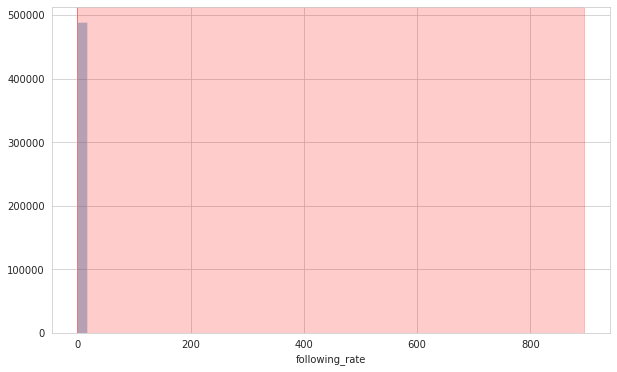

In [ ]:
plt.figure(figsize = (10,6))
sns.distplot(df_train.following_rate, kde=False)
plt.axvspan(xmin = lower,xmax= df_train.following_rate.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_train.following_rate.max(),alpha=0.2, color='red')

In [ ]:
def out_zscore(data):
    global outliers,zscore
    outliers = []
    zscore = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return print("Total number of outliers are",len(outliers))

In [ ]:
out_zscore(df_train['avgt2'])

Total number of outliers are 2979


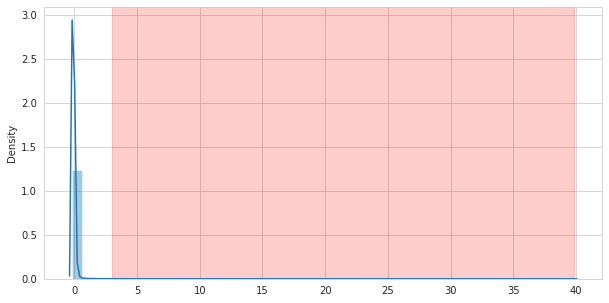

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.2, color='red')

In [ ]:
df_train.columns

Index(['tier', 'gender', 'following_rate', 'followers_avg_age',
       'following_avg_age', 'max_repetitive_punc',
       'num_of_hashtags_per_action', 'emoji_count_per_action',
       'punctuations_per_action', 'number_of_words_per_action',
       'avgCompletion', 'avgTimeSpent', 'avgDuration', 'avgComments',
       'creations', 'content_views', 'num_of_comments',
       'weekends_trails_watched_per_day', 'weekdays_trails_watched_per_day',
       'slot1_trails_watched_per_day', 'slot2_trails_watched_per_day',
       'slot3_trails_watched_per_day', 'slot4_trails_watched_per_day', 'avgt2',
       'age_group'],
      dtype='object')

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
X = df_train[['following_rate', 'followers_avg_age',
       'following_avg_age', 'max_repetitive_punc',
       'num_of_hashtags_per_action', 'emoji_count_per_action',
       'punctuations_per_action', 'number_of_words_per_action',
       'avgCompletion', 'avgTimeSpent', 'avgDuration', 'avgComments',
       'creations', 'content_views', 'num_of_comments',
       'weekends_trails_watched_per_day', 'weekdays_trails_watched_per_day',
       'slot1_trails_watched_per_day', 'slot2_trails_watched_per_day',
       'slot3_trails_watched_per_day', 'slot4_trails_watched_per_day', 'avgt2']].values
y_pred = clf.fit_predict(X)

In [ ]:
from sklearn.metrics import f1_score
f1_score(df_train['age_group'], y_pred, average='weighted')

0.47538870372276715

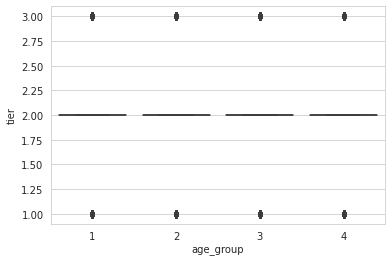

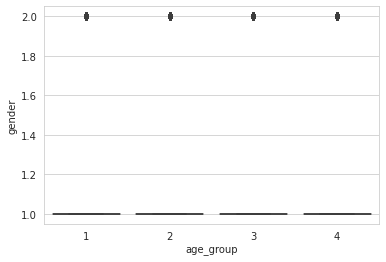

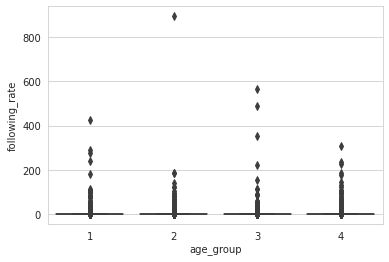

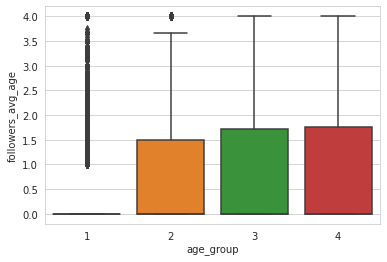

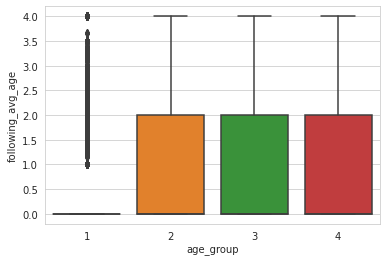

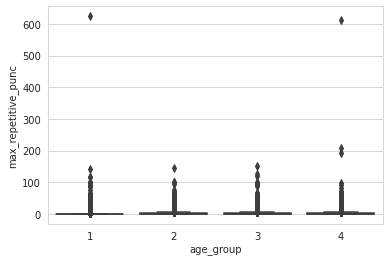

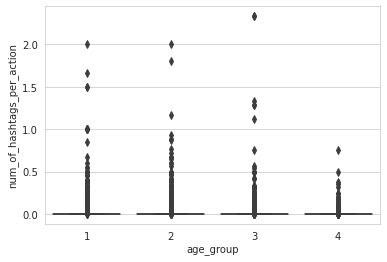

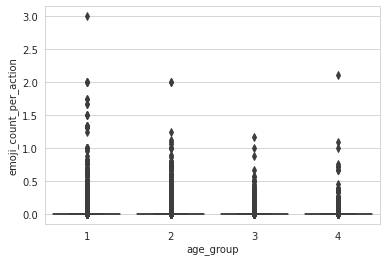

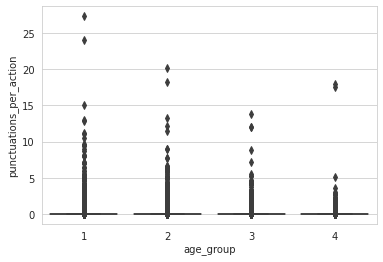

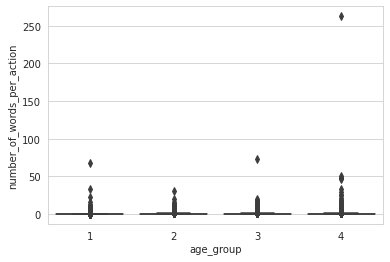

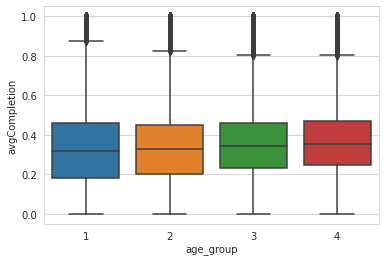

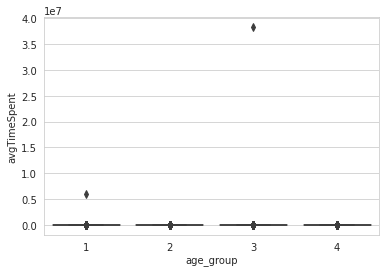

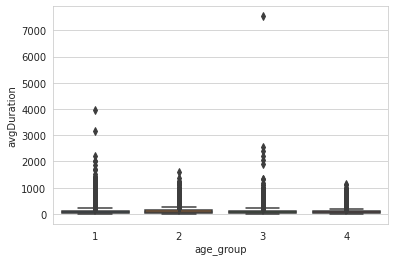

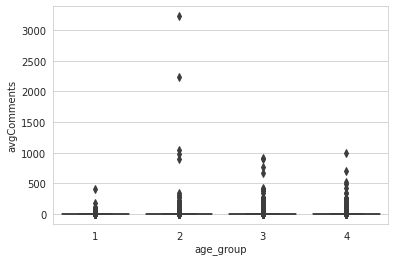

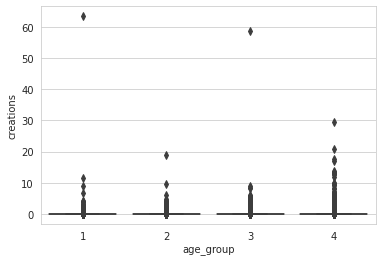

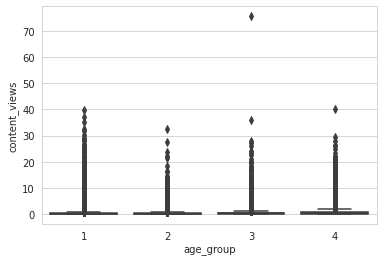

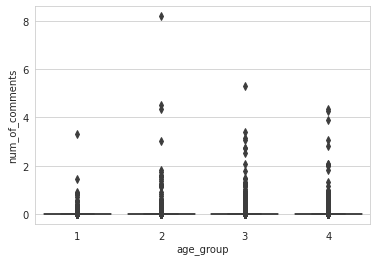

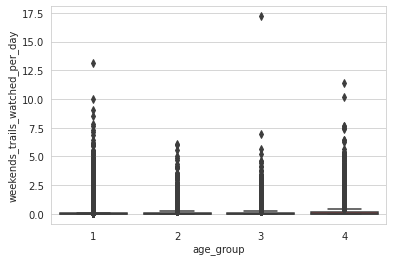

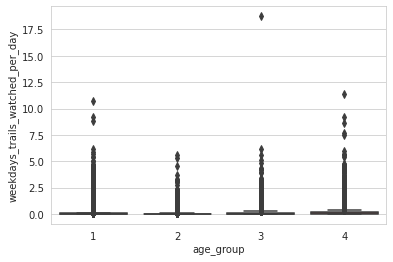

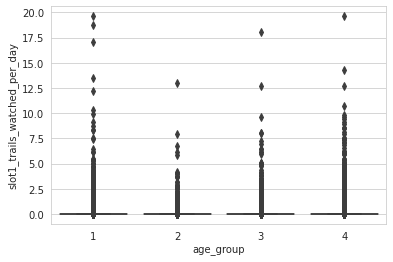

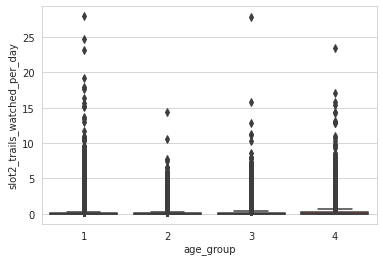

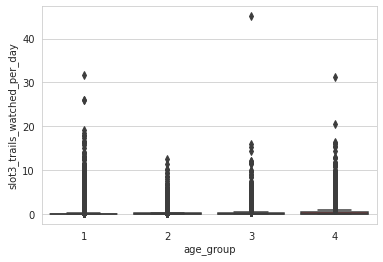

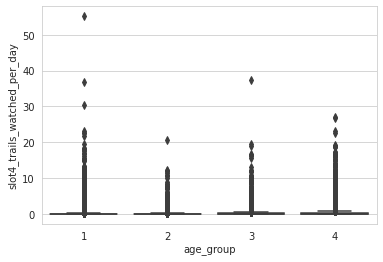

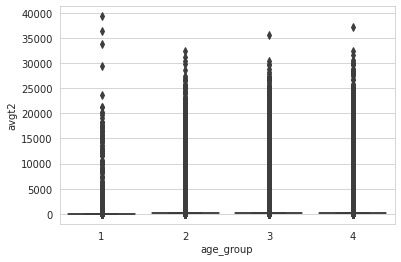

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
feature_names = df_train.columns
for i in range(len(feature_names)-1):
    figure = plt.figure()
    ax = sns.boxplot(x='age_group', y=feature_names[i], data=df_train)

In [ ]:

df = df_train.copy(deep=True) # Make a copy of original data, just in case

# Create new dataframe for each type

types = df['age_group'].unique()
d = {type: df[df['age_group'] == type] for type in types}

d[1]

,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,2,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.463330,34.160000,53.996091,0,0.000,0.200000,0.0,0.041667,0.025000,0.0,0.000000,0.175000,0.033333,0.0,1
2,2,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.341657,22.000000,83.051415,0,0.000,0.002786,0.0,0.000000,0.000557,0.0,0.002786,0.000000,0.000000,0.0,1
3,2,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.005735,3.000000,523.080000,0,0.000,0.008403,0.0,0.000000,0.001681,0.0,0.000000,0.000000,0.008403,0.0,1
4,2,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.456549,12.333333,53.766640,0,0.000,0.204918,0.0,0.000000,0.049180,0.0,0.008197,0.057377,0.180328,0.0,1
5,2,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.306116,7.200000,31.369556,0,0.000,0.072581,0.0,0.080645,0.000000,0.0,0.000000,0.000000,0.161290,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488869,2,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.307646,6.750000,97.706000,0,0.000,0.055556,0.0,0.000000,0.012698,0.0,0.000000,0.000000,0.063492,0.0,1
488871,2,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.615949,13.326923,20.857065,0,0.000,0.571429,0.0,0.000000,0.123810,0.0,0.000000,0.619048,0.000000,0.0,1
488872,2,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.3,0.422837,8.714286,56.783167,0,0.008,0.064000,0.0,0.012000,0.006400,0.0,0.008000,0.000000,0.048000,195.0,1
488875,2,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.221303,9.578947,131.188182,0,0.000,0.113821,0.0,0.000000,0.030894,0.0,0.024390,0.130081,0.000000,0.0,1


In [ ]:
# Set the quantile

low = .25
high = .75

bounds = {}
for type in types:
    filt_df = d[type].loc[:, d[type].columns != 'age_groups'] # Remove 'Type' Column
    quant_df = filt_df.quantile([low, high])
    IQR = quant_df.iloc[1,:]-  quant_df.iloc[0,:]
    quant_df.iloc[0,:] = quant_df.iloc[0,:] - 1.5*IQR
    quant_df.iloc[1,:] = quant_df.iloc[1,:] + 1.5*IQR
    bounds[type] = quant_df
    
bounds[1]


,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0.25,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.237130,-5.192576,-97.386680,0.0,0.0,-0.326012,0.0,-0.054435,-0.060702,0.0,-0.127358,-0.120690,-0.120536,0.0,1.0
0.75,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.877165,21.761956,225.623476,0.0,0.0,0.642119,0.0,0.090726,0.105541,0.0,0.212264,0.201149,0.200893,0.0,1.0


In [ ]:
# Define our new dataset by removing the outliers 

filt_df = d[1].loc[:, d[1].columns != 'age_group'] # Remove 'Type' Column
filt_df = filt_df.apply(lambda x: x[(x>bounds[1].loc[low,x.name]) & (x < bounds[1].loc[high,x.name])], axis=0)
filt_df = pd.concat([filt_df,d[1].loc[:,'age_group']], axis=1)

filt_df

,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463330,NaN,53.996091,NaN,NaN,0.200000,NaN,0.041667,0.025000,NaN,0.000000,0.175000,0.033333,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341657,NaN,83.051415,NaN,NaN,0.002786,NaN,0.000000,0.000557,NaN,0.002786,0.000000,0.000000,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005735,3.000000,NaN,NaN,NaN,0.008403,NaN,0.000000,0.001681,NaN,0.000000,0.000000,0.008403,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456549,12.333333,53.766640,NaN,NaN,0.204918,NaN,0.000000,0.049180,NaN,0.008197,0.057377,0.180328,NaN,1
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.306116,7.200000,31.369556,NaN,NaN,0.072581,NaN,0.080645,0.000000,NaN,0.000000,0.000000,0.161290,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.307646,6.750000,97.706000,NaN,NaN,0.055556,NaN,0.000000,0.012698,NaN,0.000000,0.000000,0.063492,NaN,1
488871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.615949,13.326923,20.857065,NaN,NaN,0.571429,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,1
488872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.422837,8.714286,56.783167,NaN,NaN,0.064000,NaN,0.012000,0.006400,NaN,0.008000,0.000000,0.048000,NaN,1
488875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.221303,9.578947,131.188182,NaN,NaN,0.113821,NaN,0.000000,0.030894,NaN,0.024390,0.130081,0.000000,NaN,1


In [ ]:
# Let's remove the outliers from the dataset 
df_new = {}

for type in types:
    filt_df = d[type].loc[:, d[type].columns != 'Type'] # Remove 'Type' Column
    filt_df = filt_df.apply(lambda x: x[(x>bounds[type].loc[low,x.name]) & (x < bounds[type].loc[high,x.name])], axis=0)
    df_new[type] = pd.concat([filt_df,d[type].loc[:,'age_group']], axis=1)


glassdata_new = result = pd.concat(df_new)
glassdata_new

tier  gender  following_rate  ...       avgt2  age_group  age_group
1 0        NaN     NaN             NaN  ...         NaN        NaN          1
  2        NaN     NaN             NaN  ...         NaN        NaN          1
  3        NaN     NaN             NaN  ...         NaN        NaN          1
  4        NaN     NaN             NaN  ...         NaN        NaN          1
  5        NaN     NaN             NaN  ...         NaN        NaN          1
...        ...     ...             ...  ...         ...        ...        ...
4 488850   NaN     NaN        0.024390  ...  160.000000        NaN          4
  488855   NaN     NaN        0.001812  ...  191.000000        NaN          4
  488859   NaN     NaN        0.080000  ...  156.333333        NaN          4
  488873   NaN     NaN        0.017241  ...  188.742857        NaN          4
  488874   NaN     NaN             NaN  ...  184.880000        NaN          4

[488877 rows x 26 columns]

In [ ]:

for i in range(len(feature_names)-1):
    figure = plt.figure()
    ax = sns.boxplot(x='age_group', y=feature_names[i], data=glassdata_new)

ValueError: ignored

<Figure size 432x288 with 0 Axes>

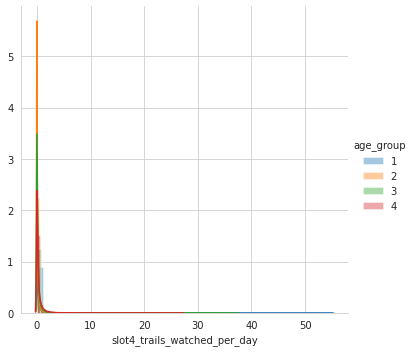

In [ ]:
sns.FacetGrid(df_train, hue="age_group", size=5) \
   .map(sns.distplot, "slot4_trails_watched_per_day") \
   .add_legend();
plt.show();

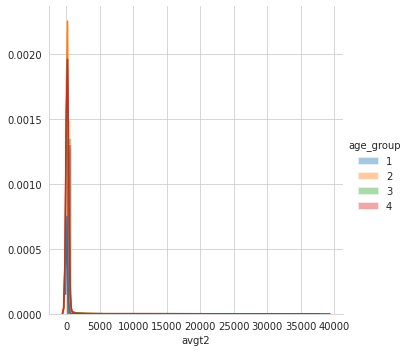

In [ ]:
sns.FacetGrid(df_train, hue="age_group", size=5) \
   .map(sns.distplot, "avgt2") \
   .add_legend();
plt.show();

In [ ]:
df_train['following_rate'] = np.log1p(df_train['following_rate'])
df_train['creations'] = np.log1p(df_train['creations'])
df_train['number_of_words_per_action'] = np.log1p(df_train['number_of_words_per_action'])
df_train['avgTimeSpent'] = np.log1p(df_train['avgTimeSpent'])
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])
df_train = df_train[df_train['avgDuration']<3000]

In [ ]:
df_train['following_rate'] = np.log1p(df_train['following_rate'])
df_train['creations'] = np.log1p(df_train['creations'])
df_train['number_of_words_per_action'] = np.log1p(df_train['number_of_words_per_action'])
df_train['avgTimeSpent'] = np.log1p(df_train['avgTimeSpent'])
df_train['creations'] = np.log1p(df_train['creations'])
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])
df_train = df_train[df_train['avgDuration']<3000]

In [ ]:
df_train.sort_values(by='creations').tail(10000)

,tier,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
421474,1,0.056452,1.500000,2.000000,8,0.000000,0.0,0.000000,0.121372,0.377291,10.330171,88.221922,2,0.120968,2.911290,0.016129,0.548387,0.630645,0.064516,1.564516,0.919355,1.701613,227.342857,1
327891,2,0.854839,1.941176,1.700000,0,0.000000,0.0,0.000000,0.296000,0.398875,9.320000,34.064867,1,0.120968,0.870968,0.008065,0.350806,0.222581,0.080645,0.145161,0.072581,1.516129,308.455556,4
383100,2,0.443548,0.000000,0.000000,0,0.000000,0.0,0.000000,0.191011,0.383070,7.030769,41.632722,1,0.120968,0.580645,0.008065,0.314516,0.083871,0.000000,0.830645,0.217742,0.000000,189.025000,3
14617,1,0.000000,0.000000,0.000000,0,0.000000,0.0,0.000000,0.191781,0.387303,8.938776,40.593642,0,0.120968,0.459677,0.000000,0.173387,0.088710,0.104839,0.096774,0.298387,0.290323,200.318841,4
99506,2,0.000000,0.000000,0.000000,5,0.000000,0.0,0.000000,0.392670,0.606970,16.773438,69.410629,0,0.120968,1.411290,0.000000,0.479839,0.220968,0.000000,0.387097,0.419355,1.258065,210.895833,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292649,1,0.023810,0.000000,0.000000,8,0.000000,0.0,0.000000,9.396677,0.422503,9.796296,63.419966,0,18.880952,0.698413,0.000000,0.023810,0.076190,0.000000,0.126984,0.190476,0.111111,198.910124,2
283452,2,0.000000,0.000000,0.000000,34,0.000000,0.0,0.000000,1.471875,0.135429,4.897321,125.408552,8,20.722222,4.066667,0.088889,0.894444,0.637778,0.377778,1.066667,1.600000,1.933333,264.926961,4
116779,2,1.421053,2.493506,2.250000,3,0.000000,0.0,0.000776,0.256921,0.198534,17.521111,137.824396,0,29.622807,4.271930,0.000000,1.407895,1.015789,1.877193,1.192982,2.149123,2.675439,252.091196,4
47788,3,0.984252,2.286822,2.236842,6,0.000000,0.0,0.000000,3.238030,0.215238,8.801749,124.911351,33,58.779528,3.771654,0.259843,0.677165,0.809449,0.661417,1.913386,1.141732,1.685039,239.585572,3


In [ ]:
df_train.describe()

,tier,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
count,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,4.888770e+05,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000
mean,1.975382,0.082233,0.347520,0.403049,0.739748,0.000277,0.000981,0.012805,0.179148,0.341582,1.087395e+02,83.104654,0.320923,0.017065,0.391013,0.002009,0.074353,0.066927,0.032855,0.141705,0.150401,0.158382,164.765782,1.741643
std,0.430707,2.467781,0.816334,0.925291,3.075954,0.012221,0.020381,0.159553,0.647588,0.195441,5.537516e+04,76.779586,7.649827,0.180402,0.905303,0.030561,0.211094,0.174791,0.193962,0.402612,0.451999,0.502065,981.988886,1.088559
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000653,1.000000e+00,0.233000,0.000000,0.000000,0.000887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199675,5.655172e+00,30.724000,0.000000,0.000000,0.040650,0.000000,0.000000,0.002265,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329743,8.500000e+00,62.501164,0.000000,0.000000,0.124031,0.000000,0.003968,0.015873,0.000000,0.011834,0.014563,0.015873,0.000000,1.000000
75%,2.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150183,0.460492,1.308654e+01,112.246500,0.000000,0.009091,0.364486,0.000000,0.060000,0.059016,0.000000,0.117188,0.118644,0.122396,178.666667,2.000000
max,3.000000,895.304000,4.000000,4.000000,624.000000,2.333333,3.000000,27.333333,262.666667,1.000000,3.826604e+07,7541.026000,3228.000000,63.388889,75.662281,8.196850,17.201754,18.756140,19.612903,27.905983,45.083333,55.153846,39304.000000,4.000000


In [ ]:
df_train['avg_age'] = df_train['following_avg_age'] + df_train['followers_avg_age']
df_train['per_action'] = df_train['num_of_hashtags_per_action'] + df_train['emoji_count_per_action'] + df_train['punctuations_per_action']
df_train['avg'] = df_train['avgCompletion'] + df_train['avgTimeSpent'] + df_train['avgDuration']
df_train['watched_per_day'] = df_train['slot1_trails_watched_per_day'] + df_train['slot2_trails_watched_per_day'] + df_train['slot3_trails_watched_per_day'] + df_train['slot4_trails_watched_per_day']

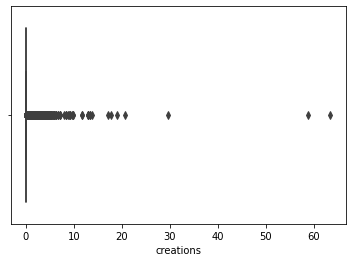

In [ ]:
sns.boxplot(x=df_train['creations'])

In [ ]:
df_trai = df_train[df_test['creations']<1]

In [ ]:
df_trai = df_train[df_train['creations']<1]

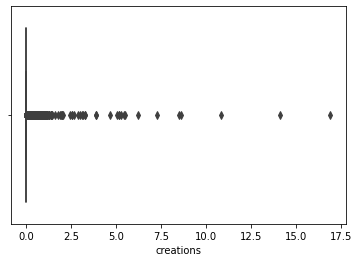

In [ ]:
sns.boxplot(x=df_test['creations'])

In [ ]:
df_trai.shape

(488317, 25)

In [ ]:
df_train = df_train[df_train['avgComments']<1500]

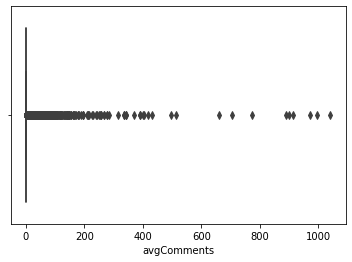

In [ ]:
sns.boxplot(x=df_train['avgComments'])

In [ ]:
df_train = df_train[df_train['avgDuration']<1200]

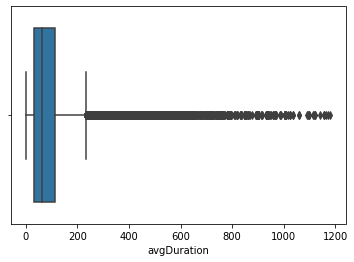

In [ ]:
sns.boxplot(x=df_train['avgDuration'])

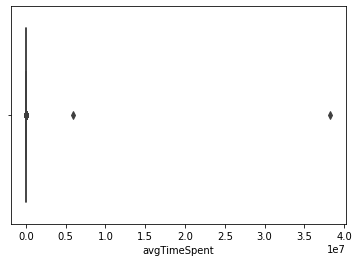

In [ ]:
sns.boxplot(x=df_train['avgTimeSpent'])

In [ ]:
df_train[df_train['avgTimeSpent']>0.3]

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,265153,48958844,2,1,0.000000,0.000,0.00,0,0.0,0.0,0.000000,0.000000,0.463330,34.160000,53.996091,0,0.000000,0.200000,0.000000,0.041667,0.025000,0.000000,0.000000,0.175000,0.033333,0.000000,1
1,405231,51100441,2,2,0.000000,0.000,0.00,0,0.0,0.0,0.076923,0.153846,0.429468,15.285714,96.231625,0,0.008475,0.093220,0.000000,0.012712,0.018644,0.000000,0.084746,0.000000,0.033898,82.500000,2
2,57867,6887426,2,1,0.000000,0.000,0.00,0,0.0,0.0,0.000000,0.000000,0.341657,22.000000,83.051415,0,0.000000,0.002786,0.000000,0.000000,0.000557,0.000000,0.002786,0.000000,0.000000,0.000000,1
3,272618,50742404,2,1,0.000000,0.000,0.00,0,0.0,0.0,0.000000,0.000000,0.005735,3.000000,523.080000,0,0.000000,0.008403,0.000000,0.000000,0.001681,0.000000,0.000000,0.000000,0.008403,0.000000,1
4,251123,45589200,2,2,0.000000,0.000,0.00,0,0.0,0.0,0.000000,0.000000,0.456549,12.333333,53.766640,0,0.000000,0.204918,0.000000,0.000000,0.049180,0.000000,0.008197,0.057377,0.180328,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488872,535266,38983571,2,2,0.000000,0.000,0.00,0,0.0,0.0,0.000000,0.300000,0.422837,8.714286,56.783167,0,0.008000,0.064000,0.000000,0.012000,0.006400,0.000000,0.008000,0.000000,0.048000,195.000000,1
488873,36706,53264639,1,1,0.017241,0.000,0.00,0,0.0,0.0,0.000000,0.012195,0.668494,35.662921,69.031216,2,0.051724,2.043103,0.017241,0.301724,0.339655,0.068966,0.922414,0.137931,1.172414,188.742857,4
488874,31570,44693578,1,1,0.229508,1.625,2.25,0,0.0,0.0,0.000000,0.094340,0.579213,13.444444,50.611380,0,0.016393,0.409836,0.000000,0.000000,0.118033,0.000000,0.049180,0.237705,0.303279,184.880000,4
488875,239209,42760145,2,1,0.000000,0.000,0.00,0,0.0,0.0,0.000000,0.000000,0.221303,9.578947,131.188182,0,0.000000,0.113821,0.000000,0.000000,0.030894,0.000000,0.024390,0.130081,0.000000,0.000000,1


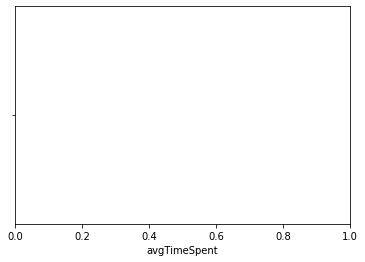

In [ ]:
sns.boxplot(x=df_train['avgTimeSpent'])

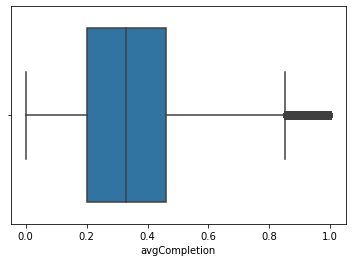

In [ ]:
sns.boxplot(x=df_train['avgCompletion'])

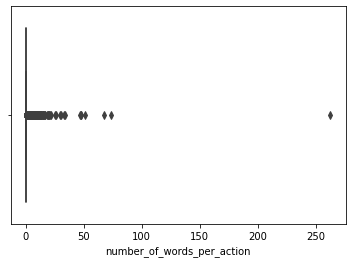

In [ ]:
sns.boxplot(x=df_train['number_of_words_per_action'])

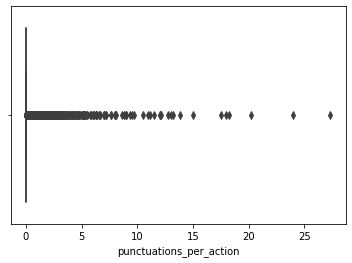

In [ ]:
sns.boxplot(x=df_train['punctuations_per_action'])

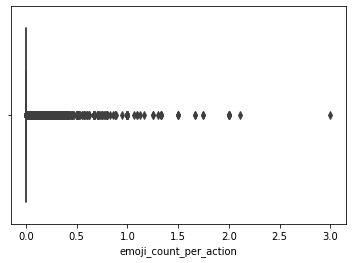

In [ ]:
sns.boxplot(x=df_train['emoji_count_per_action'])

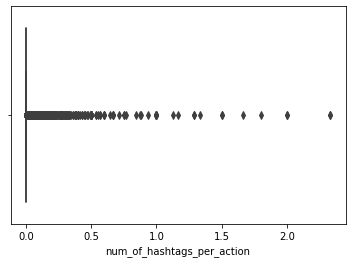

In [ ]:
sns.boxplot(x=df_train['num_of_hashtags_per_action'])

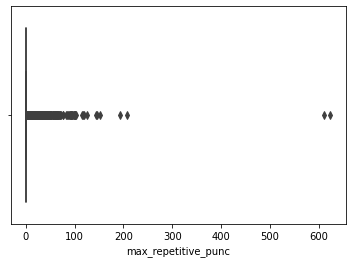

In [ ]:
sns.boxplot(x=df_train['max_repetitive_punc'])

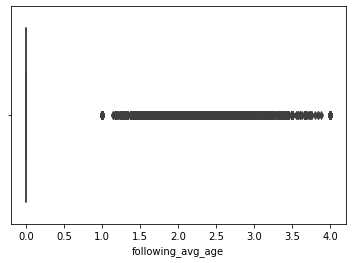

In [ ]:
sns.boxplot(x=df_train['following_avg_age'])

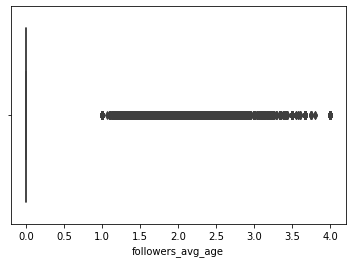

In [ ]:
sns.boxplot(x=df_train['followers_avg_age'])

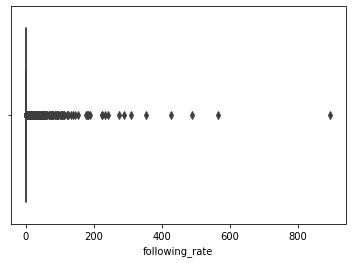

In [ ]:
sns.boxplot(x=df_train['following_rate'])

In [ ]:
df_train.head()

,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.463330,34.160000,53.996091,0,0.000000,0.200000,0.0,0.041667,0.025000,0.0,0.000000,0.175000,0.033333,0.0,1
1,2,2,0.0,0.0,0.0,0,0.0,0.0,0.076923,0.153846,0.429468,15.285714,96.231625,0,0.008475,0.093220,0.0,0.012712,0.018644,0.0,0.084746,0.000000,0.033898,82.5,2
2,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.341657,22.000000,83.051415,0,0.000000,0.002786,0.0,0.000000,0.000557,0.0,0.002786,0.000000,0.000000,0.0,1
3,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.005735,3.000000,523.080000,0,0.000000,0.008403,0.0,0.000000,0.001681,0.0,0.000000,0.000000,0.008403,0.0,1
4,2,2,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.456549,12.333333,53.766640,0,0.000000,0.204918,0.0,0.000000,0.049180,0.0,0.008197,0.057377,0.180328,0.0,1


In [ ]:
df = pd.concat([df_train,df_test],ignore_index=True)
df = pd.get_dummies(df, columns=['gender','tier','max_repetitive_punc','num_of_hashtags_per_action','emoji_count_per_action','punctuations_per_action','avgComments','num_of_comments'])


In [ ]:
from imblearn.over_sampling import KMeansSMOTE

print('Original dataset shape {}'.format(Counter(y_train)))
sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_sample(train_pro, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 308315, 4: 60803, 3: 60404, 2: 59355})
Resampled dataset shape Counter({4: 253923, 2: 252879, 3: 251437, 1: 219312})


In [ ]:
df_train = pd.DataFrame(X_res)

In [ ]:
df_train['train_age']=y_res

In [ ]:
train=df_train

In [ ]:
print('Original dataset shape {}'.format(Counter(y_train)))
sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_sample(train_pro, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

features = [c for c in train.columns if c not in ['train_age']]

In [ ]:
oofs = np.zeros((len(train), 4))
preds = np.zeros((len(df_test), 4))
N_SPLITS = 5
folds = StratifiedKFold(N_SPLITS, shuffle = True, random_state = 77)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['train_age'])):

  print(f'\n\n Fold {fold_} \\n\n')
  X_trn, y_trn = train[features].iloc[trn_idx], train["train_age"][trn_idx]
  X_val, y_val = train[features].iloc[val_idx], train["train_age"][val_idx]

  clf = LGBMClassifier(n_estimators = 2000, learning_rate = 0.03, colsample_bytree = 0.3, reg_alpha = 0.5, reg_lambda = 2, random_state = 2)

  #clf = CatBoostClassifier(iterations = 5000, )

  clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], early_stopping_rounds = 150, verbose = 50)

  oofs[val_idx] = clf.predict_proba(X_val)
  preds += clf.predict_proba(df_test) / N_SPLITS




 Fold 0 \n

Training until validation scores don't improve for 150 rounds.
[50]	valid_0's multi_logloss: 0.958437
[100]	valid_0's multi_logloss: 0.841316
[150]	valid_0's multi_logloss: 0.792837
[200]	valid_0's multi_logloss: 0.768313
[250]	valid_0's multi_logloss: 0.754912
[300]	valid_0's multi_logloss: 0.747169
[350]	valid_0's multi_logloss: 0.741859
[400]	valid_0's multi_logloss: 0.738189
[450]	valid_0's multi_logloss: 0.735009
[500]	valid_0's multi_logloss: 0.732561
[550]	valid_0's multi_logloss: 0.730368
[600]	valid_0's multi_logloss: 0.728411
[650]	valid_0's multi_logloss: 0.726631
[700]	valid_0's multi_logloss: 0.725214
[750]	valid_0's multi_logloss: 0.723744
[800]	valid_0's multi_logloss: 0.722412
[850]	valid_0's multi_logloss: 0.721252
[900]	valid_0's multi_logloss: 0.720125
[950]	valid_0's multi_logloss: 0.71908
[1000]	valid_0's multi_logloss: 0.718115
[1050]	valid_0's multi_logloss: 0.717198
[1100]	valid_0's multi_logloss: 0.716296
[1150]	valid_0's multi_logloss: 0.715379
[

KeyboardInterrupt: ignored

In [59]:
#df_train  = df_train[:10000]

In [7]:
df = pd.concat([df_train,df_test],ignore_index=True)
df = pd.get_dummies(df, columns=['gender','tier'])
#df = pd.get_dummies(df, columns=['gender','tier','max_repetitive_punc','num_of_hashtags_per_action','emoji_count_per_action','punctuations_per_action','avgComments','num_of_comments'],sparse=True)

In [8]:
TARGET_COL ='age_group'

In [9]:
train_proc, test_proc = df[:df_train.shape[0]], df[df_train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [TARGET_COL]]

In [10]:
from imblearn.over_sampling import KMeansSMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter( train_proc[TARGET_COL])))
sm = KMeansSMOTE(random_state=42)
train_proc[features], train_proc[TARGET_COL] = sm.fit_resample(train_proc[features], train_proc[TARGET_COL])
print('Resampled dataset shape {}'.format(Counter(train_proc[TARGET_COL])))

Original dataset shape Counter({1.0: 308315, 4.0: 60803, 3.0: 60404, 2.0: 59355})


KeyboardInterrupt: ignored

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(train_proc[features],train_proc[TARGET_COL], test_size=0.25, random_state=42)

In [11]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os

In [12]:
train_proc.columns

Index(['following_rate', 'followers_avg_age', 'following_avg_age',
       'max_repetitive_punc', 'num_of_hashtags_per_action',
       'emoji_count_per_action', 'punctuations_per_action',
       'number_of_words_per_action', 'avgCompletion', 'avgTimeSpent',
       'avgDuration', 'avgComments', 'creations', 'content_views',
       'num_of_comments', 'weekends_trails_watched_per_day',
       'weekdays_trails_watched_per_day', 'slot1_trails_watched_per_day',
       'slot2_trails_watched_per_day', 'slot3_trails_watched_per_day',
       'slot4_trails_watched_per_day', 'avgt2', 'age_group', 'gender_1',
       'gender_2', 'tier_1', 'tier_2', 'tier_3'],
      dtype='object')

In [13]:
target = "age_group"

bool_columns = [
    'gender_1','gender_2', 'tier_1', 'tier_2', 'tier_3'
]

int_columns = [
               'following_rate', 'followers_avg_age', 'following_avg_age',
       'max_repetitive_punc', 'num_of_hashtags_per_action',
       'emoji_count_per_action', 'punctuations_per_action',
       'number_of_words_per_action', 'avgCompletion', 'avgTimeSpent',
       'avgDuration', 'avgComments', 'creations', 'content_views',
       'num_of_comments', 'weekends_trails_watched_per_day',
       'weekdays_trails_watched_per_day', 'slot1_trails_watched_per_day',
       'slot2_trails_watched_per_day', 'slot3_trails_watched_per_day',
       'slot4_trails_watched_per_day', 'avgt2'
]

feature_columns = (
    int_columns + bool_columns + [target])

In [14]:
train = train_proc

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

#train_val_indices, test_indices = train_test_split(
#    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)

In [15]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

In [16]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [17]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cuda


In [18]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

#X_test = train[features].values[test_indices]
#y_test = train[target].values[test_indices]

In [19]:
max_epochs = 100 
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256
)

Optimal number of features : 27
Best features : Index(['Unnamed: 0', 'userId', 'following_rate', 'followers_avg_age',
       'following_avg_age', 'max_repetitive_punc',
       'num_of_hashtags_per_action', 'emoji_count_per_action',
       'punctuations_per_action', 'number_of_words_per_action',
       'avgCompletion', 'avgTimeSpent', 'avgDuration', 'avgComments',
       'creations', 'content_views', 'num_of_comments',
       'weekends_trails_watched_per_day', 'weekdays_trails_watched_per_day',
       'slot1_trails_watched_per_day', 'slot2_trails_watched_per_day',
       'slot3_trails_watched_per_day', 'slot4_trails_watched_per_day', 'avgt2',
       'gender_1', 'gender_2', 'tier_2'],
      dtype='object')


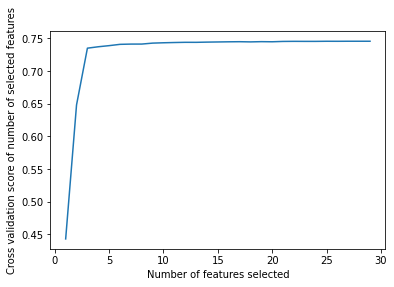

In [14]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = LGBMClassifier(class_weight='balanced') 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=3,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(train_proc[features], train_proc['age_group'])

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', train_proc[features].columns[rfecv.support_])

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
train_proc.shape

(488877, 25)

In [10]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def av_metric(y_true, y_pred):
  return (f1_score(y_true, y_pred, average='weighted'))

In [11]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5

  oofs = np.zeros((len(train),1))
  preds = np.zeros((len(test), 4))


  folds = StratifiedKFold(n_splits = N_SPLITS)
  feature_importances = pd.DataFrame()

  target = train[TARGET_COL]

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    #scaler = StandardScaler()
    #_ = scaler.fit(X_trn)

    #X_trn = scaler.transform(X_trn)
    #X_val = scaler.transform(X_val)
    #X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += clf.predict_proba(X_test) / N_SPLITS

  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')
  sns.heatmap(confusion_matrix(target, oofs), annot=True, cmap = 'viridis', fmt='.0f')
  plt.show()

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

In [74]:
features = ['tier', 'gender',
       'followers_avg_age', 'max_repetitive_punc','number_of_words_per_action',
       'avgCompletion', 'avgTimeSpent', 'avgDuration', 'avgComments',
       'creations', 'content_views', 'avgt2']

In [75]:
clf = CatBoostClassifier(#n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc,features)


------------- Fold 1 -------------
0:	learn: 1.3708990	test: 1.3709347	best: 1.3709347 (0)	total: 239ms	remaining: 3m 58s
200:	learn: 0.7044341	test: 0.7059913	best: 0.7059913 (200)	total: 44.5s	remaining: 2m 56s
400:	learn: 0.6409396	test: 0.6427874	best: 0.6427874 (400)	total: 1m 28s	remaining: 2m 12s
600:	learn: 0.6237972	test: 0.6258260	best: 0.6258260 (600)	total: 2m 12s	remaining: 1m 27s
800:	learn: 0.6127551	test: 0.6150282	best: 0.6150282 (800)	total: 2m 55s	remaining: 43.6s
999:	learn: 0.6046082	test: 0.6071866	best: 0.6071866 (999)	total: 3m 38s	remaining: 0us

bestTest = 0.6071865589
bestIteration = 999


AV metric score for validation set is 0.717857827508169

------------- Fold 2 -------------
0:	learn: 1.3709118	test: 1.3708961	best: 1.3708961 (0)	total: 238ms	remaining: 3m 57s


KeyboardInterrupt: ignored

In [23]:
train_proc['creations'] = np.log1p(train_proc['creations'])

In [29]:
train_proc.head(2)

,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group,gender_1,gender_2,tier_1,tier_2,tier_3
0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.463330,34.160000,53.996091,0,0.000000,0.20000,0.0,0.041667,0.025000,0.0,0.000000,0.175,0.033333,0.0,1.0,1,0,0,1,0
1,0.0,0.0,0.0,0,0.0,0.0,0.076923,0.153846,0.429468,15.285714,96.231625,0,0.008439,0.09322,0.0,0.012712,0.018644,0.0,0.084746,0.000,0.033898,82.5,2.0,0,1,0,1,0


In [30]:
train_proc.describe()

,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group,gender_1,gender_2,tier_1,tier_2,tier_3
count,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,4.888770e+05,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000
mean,0.082233,0.347520,0.403049,0.739748,0.000277,0.000981,0.012805,0.179148,0.341582,1.087395e+02,83.104654,0.320923,0.014333,0.391013,0.002009,0.074353,0.066927,0.032855,0.141705,0.150401,0.158382,164.765782,1.741643,0.786963,0.213037,0.105366,0.813886,0.080748
std,2.467781,0.816334,0.925291,3.075954,0.012221,0.020381,0.159553,0.647588,0.195441,5.537516e+04,76.779586,7.649827,0.056352,0.905303,0.030561,0.211094,0.174791,0.193962,0.402612,0.451999,0.502065,981.988886,1.088559,0.409454,0.409454,0.307025,0.389199,0.272449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000653,1.000000e+00,0.233000,0.000000,0.000000,0.000887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199675,5.655172e+00,30.724000,0.000000,0.000000,0.040650,0.000000,0.000000,0.002265,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329743,8.500000e+00,62.501164,0.000000,0.000000,0.124031,0.000000,0.003968,0.015873,0.000000,0.011834,0.014563,0.015873,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150183,0.460492,1.308654e+01,112.246500,0.000000,0.009050,0.364486,0.000000,0.060000,0.059016,0.000000,0.117188,0.118644,0.122396,178.666667,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,895.304000,4.000000,4.000000,624.000000,2.333333,3.000000,27.333333,262.666667,1.000000,3.826604e+07,7541.026000,3228.000000,4.164941,75.662281,8.196850,17.201754,18.756140,19.612903,27.905983,45.083333,55.153846,39304.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
avgCompletion	Average watch time completion rate of the videos.
avgTimeSpent	Average time spent by the user on a video in seconds.
avgDuration	Average duration of the videos that the user has watched till date.
avgComments	Average number of comments per video watched.
creations	Total number of videos uploaded by the user.
content_views	Total number of videos watched.


In [ ]:
df['following_rate*following_avg_age'] = df['following_avg_age']*df['following_rate']
df['num_of_hashtags_per_action*following_avg_age'] = df['num_of_hashtags_per_action']*df['following_rate']
df['emoji_count_per_action*following_avg_age'] = df['emoji_count_per_action']*df['following_rate']
df['number_of_words_per_action*following_avg_age'] = df['number_of_words_per_action']*df['following_rate']
df['punctuations_per_action*following_avg_age'] = df['punctuations_per_action']*df['following_rate']

df['avgTimeSpent*creations'] = df['avgTimeSpent']*df['creations']
df['avgDuration*creations'] = df['avgDuration']*df['creations']
df['avgComments*creations'] = df['avgComments']*df['creations']
df['avgCompletion*creations'] = df['avgCompletion']*df['creations']

In [ ]:
#Total number of comments made by the user (normalized)

In [39]:
train_proc['following_rate*following_avg_age'] = train_proc['following_avg_age']*train_proc['following_rate']
train_proc['num_of_hashtags_per_action*following_avg_age'] = train_proc['num_of_hashtags_per_action']*train_proc['following_rate']
train_proc['emoji_count_per_action*following_avg_age'] = train_proc['emoji_count_per_action']*train_proc['following_rate']
train_proc['number_of_words_per_action*following_avg_age'] = train_proc['number_of_words_per_action']*train_proc['following_rate']
train_proc['punctuations_per_action*following_avg_age'] = train_proc['punctuations_per_action']*train_proc['following_rate']

In [47]:
train_proc['avgTimeSpent*creations'] = train_proc['avgTimeSpent']*train_proc['content_views']
train_proc['avgDuration*creations'] = train_proc['avgDuration']*train_proc['content_views']
train_proc['avgComments*creations'] = train_proc['avgComments']*train_proc['content_views']
train_proc['avgCompletion*creations'] = train_proc['avgCompletion']*train_proc['content_views']

In [48]:
from sklearn.preprocessing import normalize

In [12]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test), 4))


  folds = StratifiedKFold(n_splits = N_SPLITS)
  feature_importances = pd.DataFrame()

  target = train[TARGET_COL]

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    #scaler = StandardScaler()
    #_ = scaler.fit(X_trn)

    #X_trn = scaler.transform(X_trn)
    #X_val = scaler.transform(X_val)
    #X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += clf.predict_proba(X_test) / N_SPLITS

  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')
  sns.heatmap(confusion_matrix(target, oofs), annot=True, cmap = 'viridis', fmt='.0f')
  plt.show()

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

In [13]:
model =LGBMClassifier()
clf = LGBMClassifier(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        #metric = 'None',
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc,features)


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's multi_logloss: 0.475601
[400]	valid_0's multi_logloss: 0.471867
[600]	valid_0's multi_logloss: 0.470643
[800]	valid_0's multi_logloss: 0.470131
[1000]	valid_0's multi_logloss: 0.469694
Did not meet early stopping. Best iteration is:
[995]	valid_0's multi_logloss: 0.469694

AV metric score for validation set is 0.7703118992428616

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: ignored

In [22]:
model =LGBMClassifier()
model = LGBMClassifier(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )

In [23]:
from sklearn.metrics import f1_score
from statistics import mode

N_SPLITS = 5
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=False)

oofs = np.zeros(len(train_proc))

pred=[]
for i in range(0,len(test_proc)):
    pred.append([])
print(len(pred))
preds=[]

target = 'age_group'

for fold, (train_idx, val_idx) in enumerate(kf.split(X=train_proc, y=train_proc[target].values)):
    
    print(f'\n------------- Fold {fold + 1} -------------')
    
    # Training
    X_trn, y_trn = train_proc[features].iloc[train_idx], train_proc[target].iloc[train_idx]
    
    # Validation
    X_val, y_val = train_proc[features].iloc[val_idx], train_proc[target].iloc[val_idx]
    
    model.fit(X_trn, y_trn)
    
    preds_val = model.predict(X_val)
    preds_test = model.predict(test_proc[features])

    fold_score = f1_score(y_val, preds_val, average = 'weighted')
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    
    i=0
    for j in preds_test:
        pred[i].append(j)
        i+=1
        
for i in pred:
    try:
        preds.append(mode(i))
    except:
        preds.append(i[0])
preds=np.array(preds)
    
    
oofs_score = f1_score(train[target], oofs.round(), average='weighted')
print(f'\n\nF1 score for oofs is {oofs_score}')

54320

------------- Fold 1 -------------

F1 score for validation set is 0.7497505041567218

------------- Fold 2 -------------

F1 score for validation set is 0.749739721663783

------------- Fold 3 -------------

F1 score for validation set is 0.7468931550837848

------------- Fold 4 -------------

F1 score for validation set is 0.7486223494867102

------------- Fold 5 -------------


KeyboardInterrupt: ignored

In [ ]:
fi

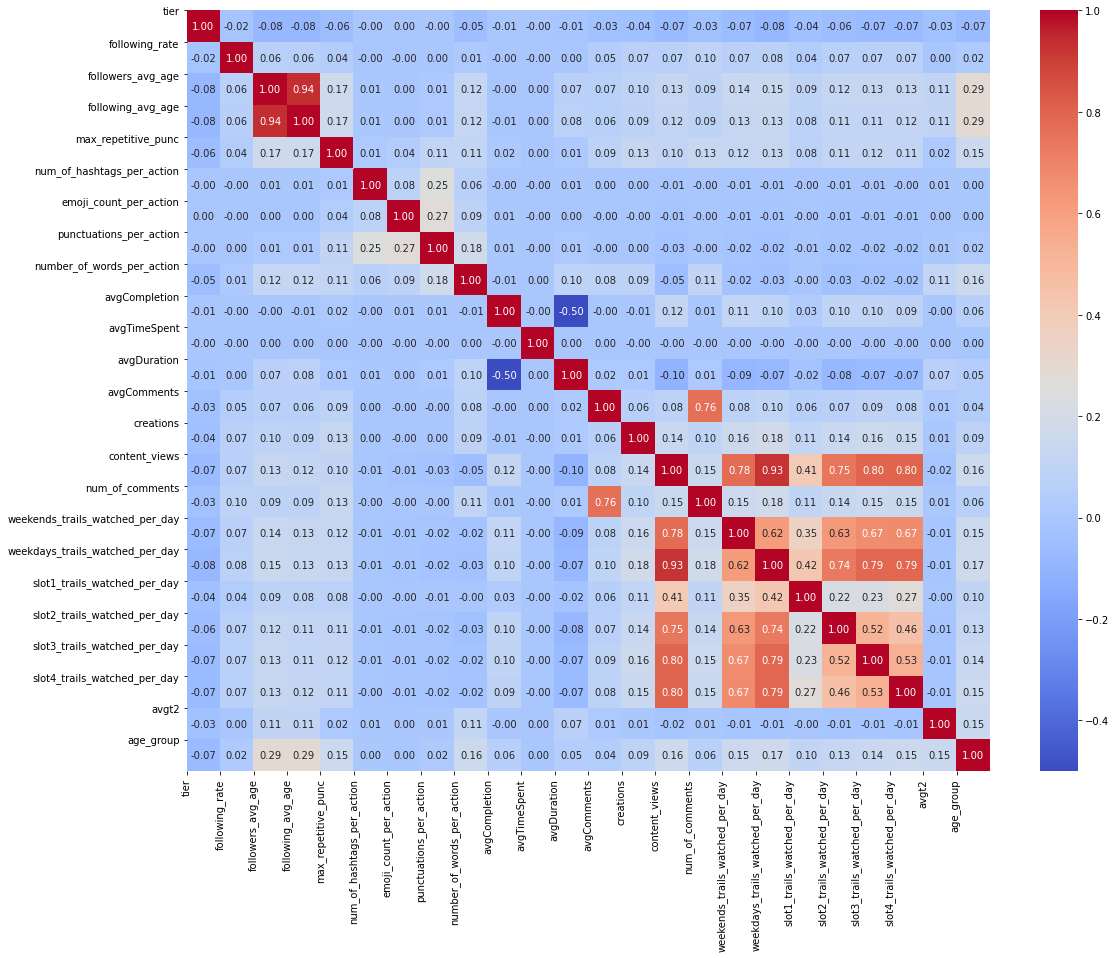

In [ ]:
corr = df_train.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(18, 14))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [22]:
fi

feature
slot3_trails_watched_per_day        0.301594
gender_2                            0.334115
gender_1                            0.342097
punctuations_per_action             0.438631
slot2_trails_watched_per_day        0.481171
slot1_trails_watched_per_day        0.536977
avgDuration                         0.660992
slot4_trails_watched_per_day        0.731070
followers_avg_age                   0.928065
num_of_comments                     1.222512
max_repetitive_punc                 1.277164
avgTimeSpent                        1.342052
following_avg_age                   1.385489
following_rate                      1.803495
content_views                       2.363398
weekdays_trails_watched_per_day     2.931167
weekends_trails_watched_per_day     3.135307
avgt2                               5.022725
number_of_words_per_action          9.880138
creations                          64.150389
Name: importance, dtype: float64

In [ ]:
df_train.describe()

,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
count,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,4.888740e+05,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000,488874.000000
mean,1.975380,1.213036,0.082233,0.347520,0.403048,0.739753,0.000277,0.000981,0.012805,0.179146,0.341584,1.087400e+02,83.075193,0.096481,0.014333,0.391015,0.002009,0.074353,0.066928,0.032855,0.141706,0.150402,0.158383,164.765927,1.741643
std,0.430706,0.409454,2.467789,0.816336,0.925291,3.075963,0.012221,0.020381,0.159554,0.647589,0.195441,5.537533e+04,75.705722,0.359073,0.056352,0.905306,0.030561,0.211095,0.174791,0.193962,0.402613,0.452000,0.502067,981.991864,1.088560
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000653,1.000000e+00,0.233000,0.000000,0.000000,0.000887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199677,5.655172e+00,30.723608,0.000000,0.000000,0.040650,0.000000,0.000000,0.002268,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329744,8.500000e+00,62.500897,0.000000,0.000000,0.124031,0.000000,0.003968,0.015873,0.000000,0.011834,0.014572,0.015873,0.000000,1.000000
75%,2.000000,1.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150137,0.460493,1.308606e+01,112.245150,0.000000,0.009050,0.364486,0.000000,0.060000,0.059016,0.000000,0.117188,0.118644,0.122413,178.666667,2.000000
max,3.000000,2.000000,895.304000,4.000000,4.000000,624.000000,2.333333,3.000000,27.333333,262.666667,1.000000,3.826604e+07,2545.164333,8.079928,4.164941,75.662281,8.196850,17.201754,18.756140,19.612903,27.905983,45.083333,55.153846,39304.000000,4.000000


In [ ]:
df_train['avgt2'] = np.log1p(df_train['avgt2'])

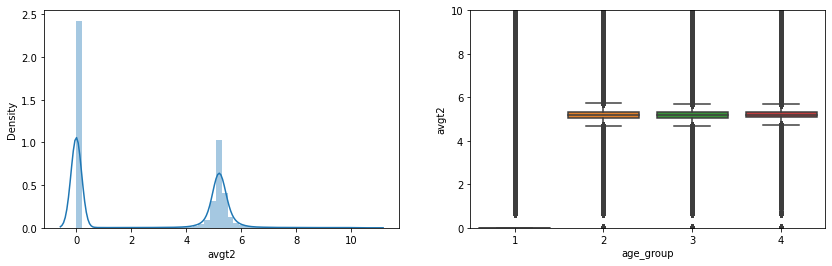

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['avgt2'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'avgt2', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=10);
plt.show()

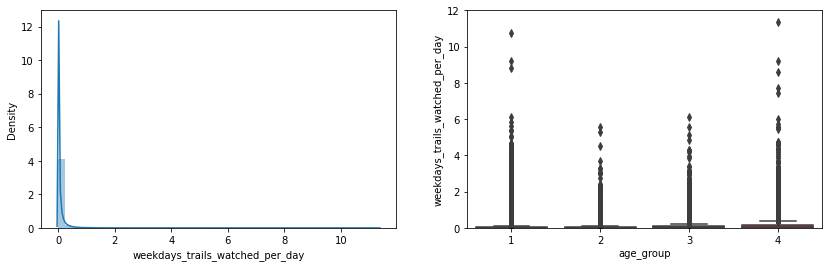

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['weekdays_trails_watched_per_day'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'weekdays_trails_watched_per_day', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=12);
plt.show()

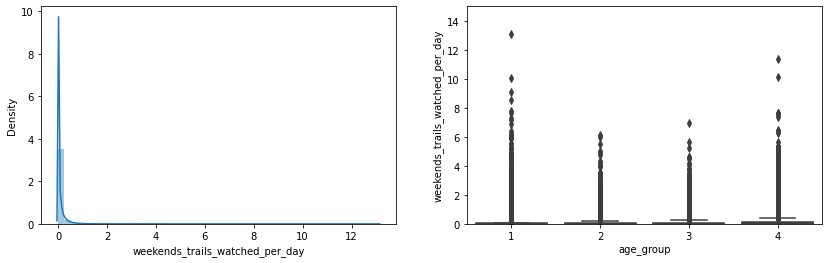

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['weekends_trails_watched_per_day'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'weekends_trails_watched_per_day', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=15);
plt.show()

In [ ]:
df_train['num_of_comments'] = np.log1p(df_train['num_of_comments'])

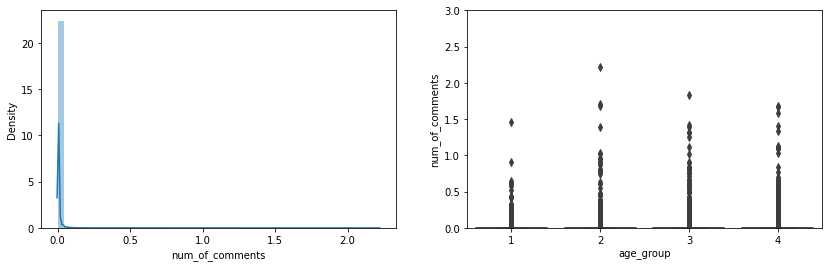

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['num_of_comments'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'num_of_comments', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=3);
plt.show()

In [ ]:
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])

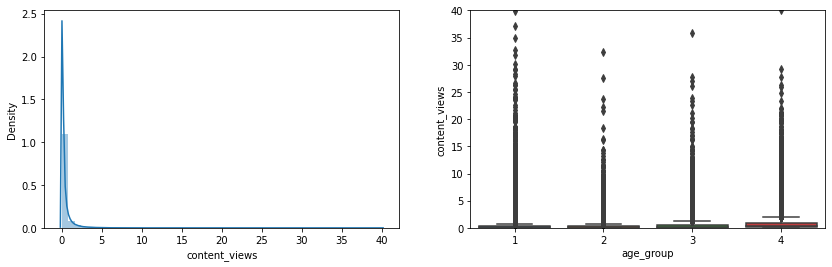

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['content_views'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'content_views', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=40);
plt.show()

In [ ]:
df_train['creations'] = np.log1p(df_train['creations'])
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])

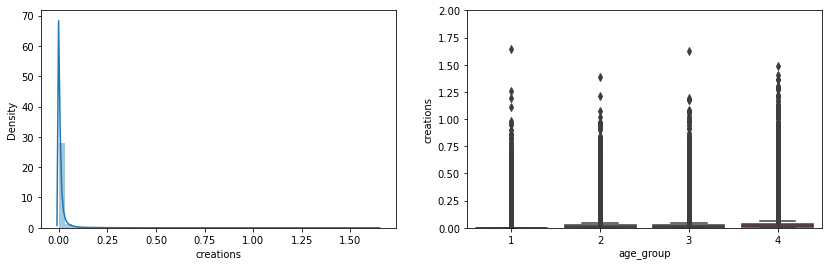

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['creations'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'creations', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=2);
plt.show()

In [ ]:
df_train['avgComments'] = np.log1p(df_train['avgComments'])

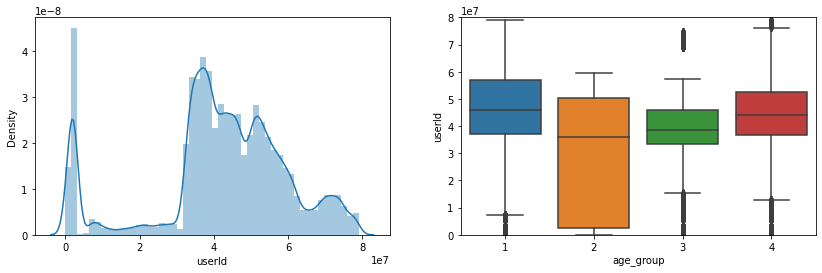

In [39]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['userId'], ax = axes[0])
sns.boxplot(x = 'age_group', y ='userId', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=80000000);
plt.show()

In [ ]:
df_train['creations'] = np.log1p(df_train['creations'])
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])
df_train = df_train[df_train['avgDuration']<3000]

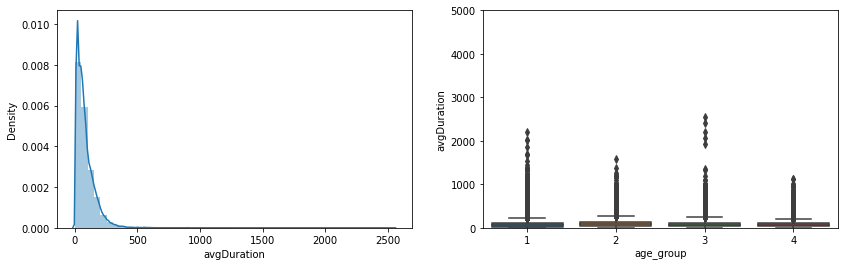

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['avgDuration'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'avgDuration', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=5000);
plt.show()

In [ ]:
df_train['avgTimeSpent'] = np.log1p(df_train['avgTimeSpent'])
df_train['creations'] = np.log1p(df_train['creations'])
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])
df_train = df_train[df_train['avgDuration']<3000]

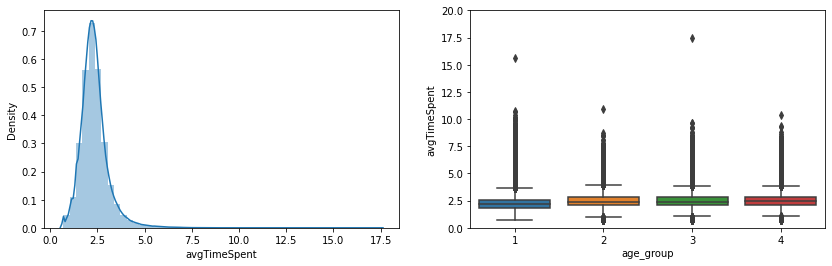

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['avgTimeSpent'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'avgTimeSpent', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=20);
plt.show()

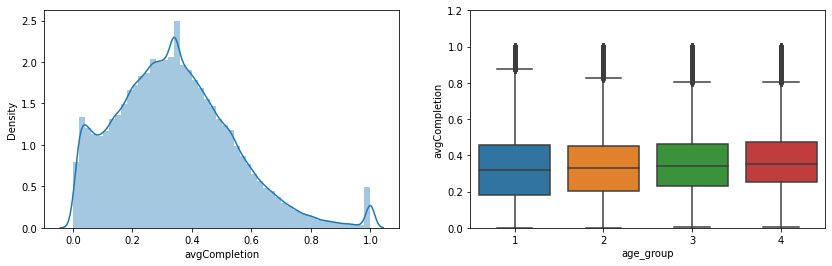

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['avgCompletion'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'avgCompletion', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=1.2);
plt.show()

In [ ]:
df_train['number_of_words_per_action'] = np.log1p(df_train['number_of_words_per_action'])
df_train['avgTimeSpent'] = np.log1p(df_train['avgTimeSpent'])
df_train['creations'] = np.log1p(df_train['creations'])
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])
df_train = df_train[df_train['avgDuration']<3000]

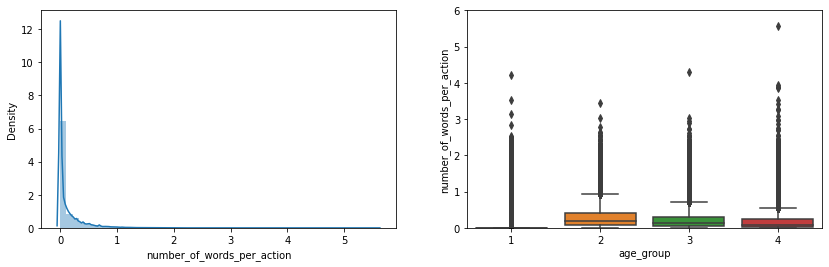

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['number_of_words_per_action'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'number_of_words_per_action', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=6);
plt.show()

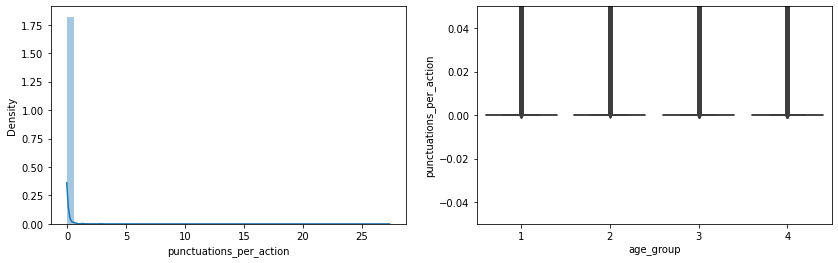

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['punctuations_per_action'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'punctuations_per_action', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=0.000);
plt.show()

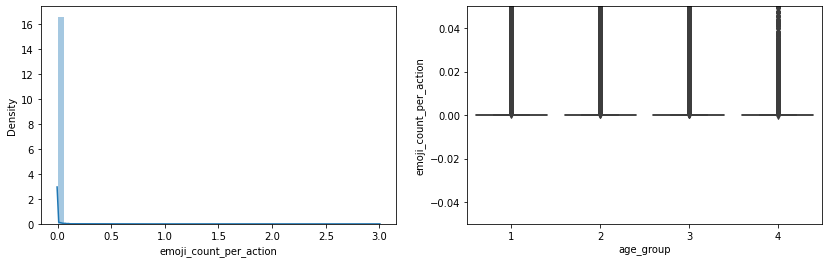

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['emoji_count_per_action'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'emoji_count_per_action', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=0.000);
plt.show()

In [ ]:
df_train['num_of_hashtags_per_action'] = np.log1p(df_train['num_of_hashtags_per_action'])

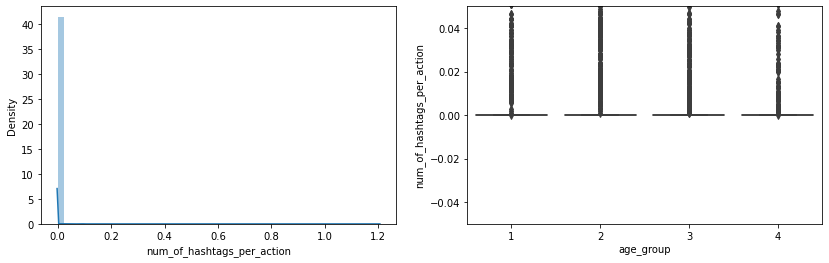

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['num_of_hashtags_per_action'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'num_of_hashtags_per_action', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=0.000);
plt.show()

In [ ]:
1df_train['max_repetitive_punc'] = np.log1p(df_train['max_repetitive_punc'])

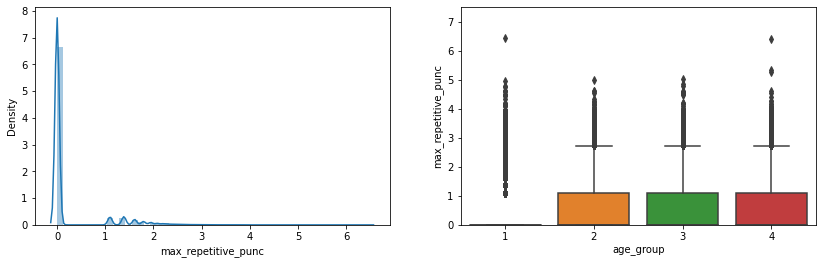

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['max_repetitive_punc'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'max_repetitive_punc', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=7.5);
plt.show()

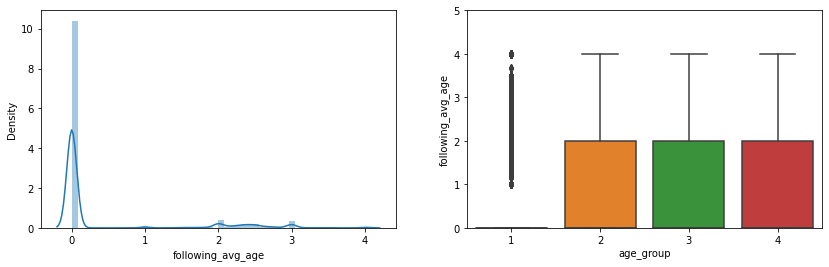

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['following_avg_age'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'following_avg_age', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=5);
plt.show()

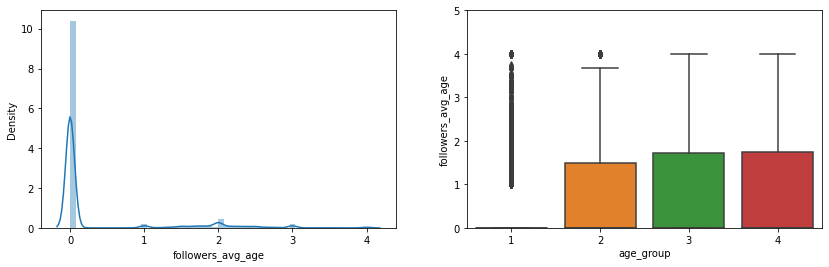

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['followers_avg_age'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'followers_avg_age', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=5);
plt.show()

In [ ]:
df_train['following_rate'] = np.log1p(df_train['following_rate'])
df_train['creations'] = np.log1p(df_train['creations'])
df_train['number_of_words_per_action'] = np.log1p(df_train['number_of_words_per_action'])
df_train['avgTimeSpent'] = np.log1p(df_train['avgTimeSpent'])
df_train['creations'] = np.log1p(df_train['creations'])
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])
df_train = df_train[df_train['avgDuration']<3000]

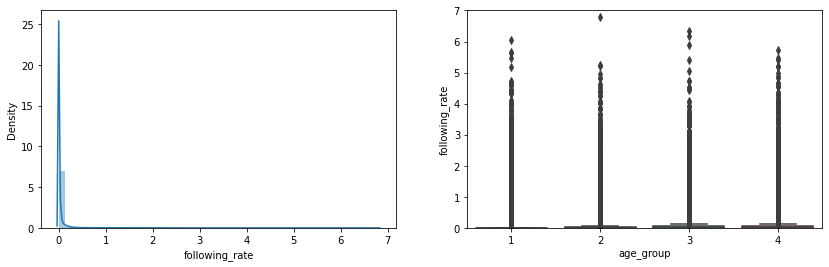

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['following_rate'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'following_rate', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=7);
plt.show()

In [ ]:
df_train['creations'] = np.log1p(df_train['creations'])
df_train['number_of_words_per_action'] = np.log1p(df_train['number_of_words_per_action'])
df_train['avgTimeSpent'] = np.log1p(df_train['avgTimeSpent'])
df_train['creations'] = np.log1p(df_train['creations'])
df_train = df_train[df_train['content_views']<40]
df_train['avgt2'] = np.log1p(df_train['avgt2'])
df_train = df_train[df_train['avgDuration']<3000]

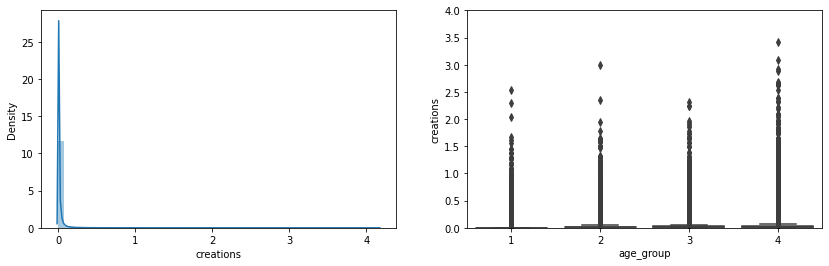

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))
sns.distplot(df_train['creations'], ax = axes[0])
sns.boxplot(x = 'age_group', y = 'creations', data = df_train,ax = axes[1])
axes[1].axis(ymin=0, ymax=4);
plt.show()

In [ ]:
f, axes = plt.subplots(1,2,figsize=(14,4))

sns.distplot(dataset['RI'], ax = axes[0])
axes[0].set_xlabel('Refractive Index', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].yaxis.tick_left()

sns.violinplot(x = 'Type', y = 'RI', data = dataset, hue = 'Type', dodge = False, ax = axes[1])
axes[1].set_xlabel('Type of glass', fontsize=14)
axes[1].set_ylabel('Refractive Index', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
params = {'n_estimators':[10,50,100,300,500,700,1000],'max_depth':[15,30,50,100,200]}

etc = LGBMClassifier()
grid = RandomizedSearchCV(etc, params,n_jobs=-1, verbose=10, cv=3,scoring ='accuracy')
grid_result=grid.fit(train_proc[features],train_proc['age_group'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.5min finished


Best: 0.748012 using {'n_estimators': 700, 'max_depth': 50}
0.738200 (0.000524) with: {'n_estimators': 50, 'max_depth': 200}
0.738204 (0.000523) with: {'n_estimators': 50, 'max_depth': 15}
0.744017 (0.000350) with: {'n_estimators': 100, 'max_depth': 15}
0.747890 (0.000076) with: {'n_estimators': 500, 'max_depth': 50}
0.743670 (0.000566) with: {'n_estimators': 100, 'max_depth': 200}
0.747352 (0.000449) with: {'n_estimators': 300, 'max_depth': 15}
0.747049 (0.000301) with: {'n_estimators': 300, 'max_depth': 30}
0.668655 (0.001381) with: {'n_estimators': 10, 'max_depth': 50}
0.748012 (0.000337) with: {'n_estimators': 700, 'max_depth': 50}
0.747560 (0.000384) with: {'n_estimators': 1000, 'max_depth': 100}


In [ ]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = LGBMClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=3,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(train_proc[features], train_proc['age_group'])

KeyboardInterrupt: ignored

In [ ]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', train_pro.columns[rfecv.support_])

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

1. feature 14 (4340.000000)
2. feature 2 (951.000000)
3. feature 15 (595.000000)
4. feature 16 (528.000000)
5. feature 23 (504.000000)
6. feature 17 (476.000000)
7. feature 11 (436.000000)
8. feature 22 (434.000000)
9. feature 18 (392.000000)
10. feature 12 (383.000000)
11. feature 3 (372.000000)
12. feature 20 (357.000000)
13. feature 4 (342.000000)
14. feature 9 (320.000000)
15. feature 5 (285.000000)
16. feature 19 (253.000000)
17. feature 21 (227.000000)
18. feature 10 (209.000000)
19. feature 1 (147.000000)
20. feature 8 (138.000000)
21. feature 0 (117.000000)
22. feature 13 (91.000000)
23. feature 7 (84.000000)
24. feature 6 (19.000000)


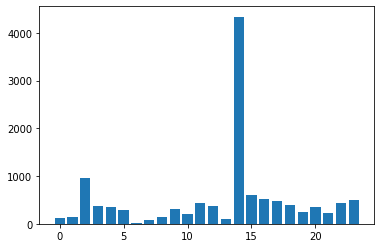

In [ ]:
# decision tree for feature importance on a regression problem
model = LGBMClassifier(class_weight='balanced')
# fit the model
model.fit(train_proc[features], train_proc['age_group'])
# get importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
for f in range(train_proc[features].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

In [ ]:
fig = sns.boxplot(x='age_group', y="creations", data=df_train)
fig.axis(ymin=0, ymax=0.8);
plt.xticks(rotation=90)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

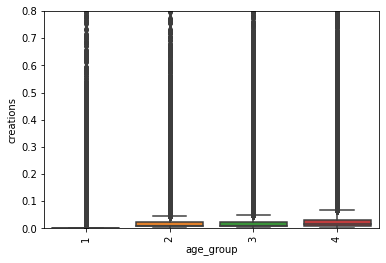

In [ ]:
fig = sns.boxplot(x='age_group', y="creations", data=df_train)
fig.axis(ymin=0, ymax=0.8);
plt.xticks(rotation=90)

In [ ]:
train_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488877 entries, 0 to 488876
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   tier                             488877 non-null  int64  
 1   gender                           488877 non-null  int64  
 2   following_rate                   488877 non-null  float64
 3   followers_avg_age                488877 non-null  float64
 4   following_avg_age                488877 non-null  float64
 5   max_repetitive_punc              488877 non-null  int64  
 6   num_of_hashtags_per_action       488877 non-null  float64
 7   emoji_count_per_action           488877 non-null  float64
 8   punctuations_per_action          488877 non-null  float64
 9   number_of_words_per_action       488877 non-null  float64
 10  avgCompletion                    488877 non-null  float64
 11  avgTimeSpent                     488877 non-null  float64
 12  av

In [ ]:
feature 1 (147.000000) 'gender','punctuations_per_action','tier','avgComments','emoji_count_per_action','num_of_hashtags_per_action'
20. feature 8 (138.000000)
21. feature 0 (117.000000)
22. feature 13 (91.000000)
23. feature 7 (84.000000)
24. feature 6 (19.000000)

In [ ]:
# To create Dataframe of predicted value with particular respective index
pred = np.argmax(lgb_preds, axis=1)
res = pd.DataFrame(pred) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.columns = ["prediction"]

def retn(x):
    if (x==0):
      return (1)
    elif (x==1):
      return (2)
    elif(x==2):
      return(3)
    else:
      return (4)

res['prediction'] = res['prediction'].apply(retn)

# To download the csv file locally
from google.colab import files
res.to_csv('z7.csv')         
files.download('z7.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import SMOTE 

from collections import Counter

In [ ]:
print('Original dataset shape {}'.format(Counter(y_train)))
sme = SMOTEENN(random_state=42)
train_proc[features], train_proc['age_group'] = sme.fit_sample(train_proc[features], train_proc['age_group'])
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 308315, 4: 60803, 3: 60404, 2: 59355})
Resampled dataset shape Counter({4.0: 253923, 2.0: 252879, 3.0: 251437, 1.0: 219312})


In [ ]:
print('Original dataset shape {}'.format(Counter(y_train)))
sme = SMOTEENN(random_state=42)
train_proc[features], train_proc['age_group'] = sme.fit_sample(train_proc[features], train_proc['age_group'])
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 308315, 4: 60803, 3: 60404, 2: 59355})


ValueError: ignored

In [ ]:
y_train = train_proc['age_group']
train_pro = train_proc.drop(['age_group'],axis=1)
#test_pro = test_proc.drop(['age_group'],axis=1)

from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#train_pro = scaler.fit_transform(train_pro)
#test_pro = scaler.transform(test_pro)

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold,TimeSeriesSplit,cross_val_score,GridSearchCV
def baseliner(X_data, y_data): # scoring can be changed roc_auc, neg_log_loss
    print("Baseliner Models(All)")
    eval_dict = {}
    models = [
              LGBMClassifier(),
        KNeighborsClassifier(),MultinomialNB(),BernoulliNB(),
        LinearDiscriminantAnalysis(),LogisticRegression(),SGDClassifier(loss='log'),SGDClassifier(loss='hinge'),
        #SVC(),
        DecisionTreeClassifier(),ExtraTreeClassifier(),
        #RandomForestClassifier(),ExtraTreesClassifier(),BaggingClassifier(),
        LGBMClassifier(),xgb.XGBClassifier(objective='binary:logistic'),CatBoostClassifier()
        ]  

    print("sklearn Model Name  \t  CV")
    print("--" * 20)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}
        #classes = y_data.unique()
        results = cross_val_score(estimator=model, X=X_data, y=y_data, cv=3, scoring='accuracy')
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))
        
baseliner(X_data = X_res, y_data = y_res)

Baseliner Models(All)
sklearn Model Name  	  CV
----------------------------------------
LGBMClassifier 	 0.6355 	


KeyboardInterrupt: ignored

In [ ]:
#df_train['whole_day'] = df_train['slot1_trails_watched_per_day']+df_train['slot2_trails_watched_per_day']+df_train['slot3_trails_watched_per_day']+df_train['slot4_trails_watched_per_day']

In [ ]:
#df_train['len_action'] = df_train['punctuations_per_action']+df_train['num_of_hashtags_per_action']+df_train['emoji_count_per_action']+df_train['number_of_words_per_action']

In [ ]:
#df_train['week_watched'] = df_train['weekends_trails_watched_per_day']+df_train['weekdays_trails_watched_per_day']

In [ ]:
#df_train['following_avg_age']

In [ ]:
df_train1 = df_train[df_train['age_group']==1]
df_train2 = df_train[df_train['age_group']!=1]

In [ ]:
df_train1 = df_train1[:50000]

In [ ]:
df = pd.concat([df_train1,df_train2],ignore_index=True)

In [ ]:
y_train = df['age_group']
train_pro = df.drop(['age_group'],axis=1)
#test_pro = test_proc.drop(['age_group'],axis=1)

from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#train_pro = scaler.fit_transform(train_pro)
#test_pro = scaler.transform(test_pro)

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold,TimeSeriesSplit,cross_val_score,GridSearchCV
def baseliner(X_data, y_data): # scoring can be changed roc_auc, neg_log_loss
    print("Baseliner Models(All)")
    eval_dict = {}
    models = [
        #KNeighborsClassifier(),MultinomialNB(),BernoulliNB(),
        #LinearDiscriminantAnalysis(),LogisticRegression(),LinearSVC(),SGDClassifier(loss='log'),SGDClassifier(loss='hinge'),
        #SVC(),
        #DecisionTreeClassifier(),ExtraTreeClassifier(),
        #RandomForestClassifier(),ExtraTreesClassifier(),BaggingClassifier(),
        LGBMClassifier(),xgb.XGBClassifier(objective='binary:logistic'),CatBoostClassifier()
        ]  

    print("sklearn Model Name  \t  CV")
    print("--" * 20)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}
        #classes = y_data.unique()
        results = cross_val_score(estimator=model, X=X_data, y=y_data, cv=3, scoring='accuracy')
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))
        
baseliner(X_data = train_pro, y_data = y_train)

Baseliner Models(All)
sklearn Model Name  	  CV
----------------------------------------
LGBMClassifier 	 0.6183 	


KeyboardInterrupt: ignored

In [ ]:
# decision tree for feature importance on a regression problem
model = LGBMClassifier()
# fit the model
model.fit(train_pro, y_train)
# get importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

1. feature 14 (1638.000000)
2. feature 23 (904.000000)
3. feature 10 (862.000000)
4. feature 12 (859.000000)
5. feature 9 (830.000000)
6. feature 11 (825.000000)
7. feature 2 (734.000000)
8. feature 18 (678.000000)
9. feature 15 (657.000000)
10. feature 20 (656.000000)
11. feature 17 (626.000000)
12. feature 21 (568.000000)
13. feature 22 (534.000000)
14. feature 19 (298.000000)
15. feature 16 (254.000000)
16. feature 3 (247.000000)
17. feature 4 (226.000000)
18. feature 5 (204.000000)
19. feature 8 (119.000000)
20. feature 0 (89.000000)
21. feature 7 (78.000000)
22. feature 1 (71.000000)
23. feature 13 (37.000000)
24. feature 6 (6.000000)


IndexError: ignored

In [ ]:
1. feature 14 (1638.000000)
2. feature 23 (904.000000)
3. feature 10 (862.000000)
4. feature 12 (859.000000)
5. feature 9 (830.000000)
6. feature 11 (825.000000)
7. feature 2 (734.000000)
8. feature 18 (678.000000)
9. feature 15 (657.000000)
10. feature 20 (656.000000)
11. feature 17 (626.000000)
12. feature 21 (568.000000)
13. feature 22 (534.000000)
14. feature 19 (298.000000)
15. feature 16 (254.000000)
16. feature 3 (247.000000)
17. feature 4 (226.000000)
18. feature 5 (204.000000)
19. feature 8 (119.000000)
20. feature 0 (89.000000)
21. feature 7 (78.000000)
22. feature 1 (71.000000)
23. feature 13 (37.000000)
24. feature 6 (6.000000)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tier                             10000 non-null  int64  
 1   gender                           10000 non-null  int64  
 2   following_rate                   10000 non-null  float64
 3   followers_avg_age                10000 non-null  float64
 4   following_avg_age                10000 non-null  float64
 5   max_repetitive_punc              10000 non-null  int64  
 6   num_of_hashtags_per_action       10000 non-null  float64
 7   emoji_count_per_action           10000 non-null  float64
 8   punctuations_per_action          10000 non-null  float64
 9   number_of_words_per_action       10000 non-null  float64
 10  avgCompletion                    10000 non-null  float64
 11  avgTimeSpent                     10000 non-null  float64
 12  avgDuration        

In [ ]:
df_train.shape

(488877, 25)

In [ ]:
df_train['age_group'].value_counts()

1    308315
4     60803
3     60404
2     59355
Name: age_group, dtype: int64

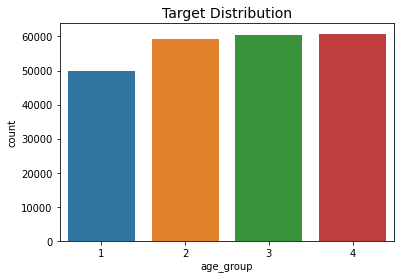

In [ ]:
_ = sns.countplot(df_train['age_group'])
_ = plt.title("Target Distribution", fontsize=14)

In [ ]:
df_train.nunique()

tier                                    3
gender                                  2
following_rate                      15453
followers_avg_age                    3495
following_avg_age                    3949
max_repetitive_punc                    95
num_of_hashtags_per_action            420
emoji_count_per_action                742
punctuations_per_action              3129
number_of_words_per_action          16664
avgCompletion                      458839
avgTimeSpent                        98838
avgDuration                        415696
avgComments                           186
creations                            9972
content_views                       32292
num_of_comments                      3881
weekends_trails_watched_per_day     20340
weekdays_trails_watched_per_day     31432
slot1_trails_watched_per_day        11765
slot2_trails_watched_per_day        20220
slot3_trails_watched_per_day        21783
slot4_trails_watched_per_day        22160
avgt2                             

In [ ]:
df_test.describe()

,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2
count,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000
mean,1.976105,1.211856,0.081204,0.344033,0.397432,0.734794,0.000357,0.000909,0.012117,0.178509,0.342335,18.350892,82.572262,0.322202,0.017718,0.393404,0.002133,0.075402,0.067343,0.032848,0.141784,0.152749,0.160141,158.286032
std,0.431142,0.408627,3.103205,0.813081,0.917988,2.822803,0.015529,0.017456,0.130576,0.600530,0.196584,245.222420,73.912128,4.606317,0.156423,0.929538,0.031136,0.212199,0.179688,0.175984,0.396400,0.481607,0.502513,920.210984
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000628,1.000000,0.767000,0.000000,0.000000,0.000873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199768,5.651071,30.447950,0.000000,0.000000,0.040816,0.000000,0.000000,0.002243,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329771,8.500000,62.443638,0.000000,0.000000,0.125000,0.000000,0.003968,0.015789,0.000000,0.011628,0.014493,0.015873,0.000000
75%,2.000000,1.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147100,0.460882,13.079052,112.135575,0.000000,0.009009,0.364427,0.000000,0.060000,0.058333,0.000000,0.117647,0.117647,0.125000,178.714286
max,3.000000,2.000000,685.277778,4.000000,4.000000,130.000000,2.333333,1.692308,12.500000,65.800000,1.000000,48286.500000,1600.786667,549.000000,16.915254,34.030303,4.575000,8.897959,8.672727,12.440000,17.060606,24.122449,22.096774,28474.333330


In [ ]:
df_test.skew()

tier                                -0.131733
gender                               1.410357
following_rate                     200.017546
followers_avg_age                    2.239967
following_avg_age                    2.036477
max_repetitive_punc                 11.299942
num_of_hashtags_per_action          91.320977
emoji_count_per_action              40.242376
punctuations_per_action             34.981229
number_of_words_per_action          38.677637
avgCompletion                        0.641512
avgTimeSpent                       150.259114
avgDuration                          2.751852
avgComments                         68.586025
creations                           58.965898
content_views                        9.628210
num_of_comments                     93.766298
weekends_trails_watched_per_day      8.731321
weekdays_trails_watched_per_day     11.594497
slot1_trails_watched_per_day        18.067113
slot2_trails_watched_per_day         9.561421
slot3_trails_watched_per_day      

In [ ]:
df_train.head()

,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,avgTimeSpent,avgDuration,avgComments,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
0,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.463330,34.160000,53.996091,0,0.000000,0.200000,0.0,0.041667,0.025000,0.0,0.000000,0.175000,0.033333,0.0,1
1,2,2,0.0,0.0,0.0,0,0.0,0.0,0.076923,0.153846,0.429468,15.285714,96.231625,0,0.008475,0.093220,0.0,0.012712,0.018644,0.0,0.084746,0.000000,0.033898,82.5,2
2,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.341657,22.000000,83.051415,0,0.000000,0.002786,0.0,0.000000,0.000557,0.0,0.002786,0.000000,0.000000,0.0,1
3,2,1,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.005735,3.000000,523.080000,0,0.000000,0.008403,0.0,0.000000,0.001681,0.0,0.000000,0.000000,0.008403,0.0,1
4,2,2,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.456549,12.333333,53.766640,0,0.000000,0.204918,0.0,0.000000,0.049180,0.0,0.008197,0.057377,0.180328,0.0,1


In [ ]:
TARGET_COL = 'age_group'

In [ ]:
df_train[TARGET_COL].value_counts(normalize=True)

1    0.630660
4    0.124373
3    0.123557
2    0.121411
Name: age_group, dtype: float64

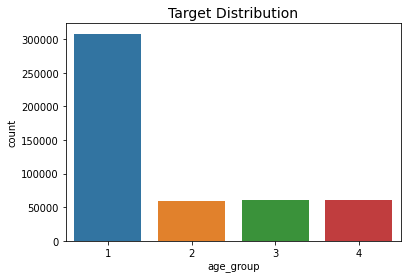

In [ ]:
_ = sns.countplot(df_train[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

In [ ]:
features = [c for c in df_train.columns if c not in [TARGET_COL]]
df_train.columns

Index(['tier', 'gender', 'following_rate', 'followers_avg_age',
       'following_avg_age', 'max_repetitive_punc',
       'num_of_hashtags_per_action', 'emoji_count_per_action',
       'punctuations_per_action', 'number_of_words_per_action',
       'avgCompletion', 'avgTimeSpent', 'avgDuration', 'avgComments',
       'creations', 'content_views', 'num_of_comments',
       'weekends_trails_watched_per_day', 'weekdays_trails_watched_per_day',
       'slot1_trails_watched_per_day', 'slot2_trails_watched_per_day',
       'slot3_trails_watched_per_day', 'slot4_trails_watched_per_day', 'avgt2',
       'age_group'],
      dtype='object')

In [ ]:
features = [c for c in df_train.columns if c not in [TARGET_COL]]
df_train.columns

Index(['tier', 'gender', 'following_rate', 'followers_avg_age',
       'following_avg_age', 'max_repetitive_punc',
       'num_of_hashtags_per_action', 'emoji_count_per_action',
       'punctuations_per_action', 'number_of_words_per_action',
       'avgCompletion', 'avgTimeSpent', 'avgDuration', 'avgComments',
       'creations', 'content_views', 'num_of_comments',
       'weekends_trails_watched_per_day', 'weekdays_trails_watched_per_day',
       'slot1_trails_watched_per_day', 'slot2_trails_watched_per_day',
       'slot3_trails_watched_per_day', 'slot4_trails_watched_per_day', 'avgt2',
       'age_group'],
      dtype='object')

In [ ]:
cat_cols = ['tier','gender']

In [ ]:
num_cols = [c for c in features if c not in cat_cols]
num_cols

['following_rate',
 'followers_avg_age',
 'following_avg_age',
 'max_repetitive_punc',
 'num_of_hashtags_per_action',
 'emoji_count_per_action',
 'punctuations_per_action',
 'number_of_words_per_action',
 'avgCompletion',
 'avgTimeSpent',
 'avgDuration',
 'avgComments',
 'creations',
 'content_views',
 'num_of_comments',
 'weekends_trails_watched_per_day',
 'weekdays_trails_watched_per_day',
 'slot1_trails_watched_per_day',
 'slot2_trails_watched_per_day',
 'slot3_trails_watched_per_day',
 'slot4_trails_watched_per_day',
 'avgt2']

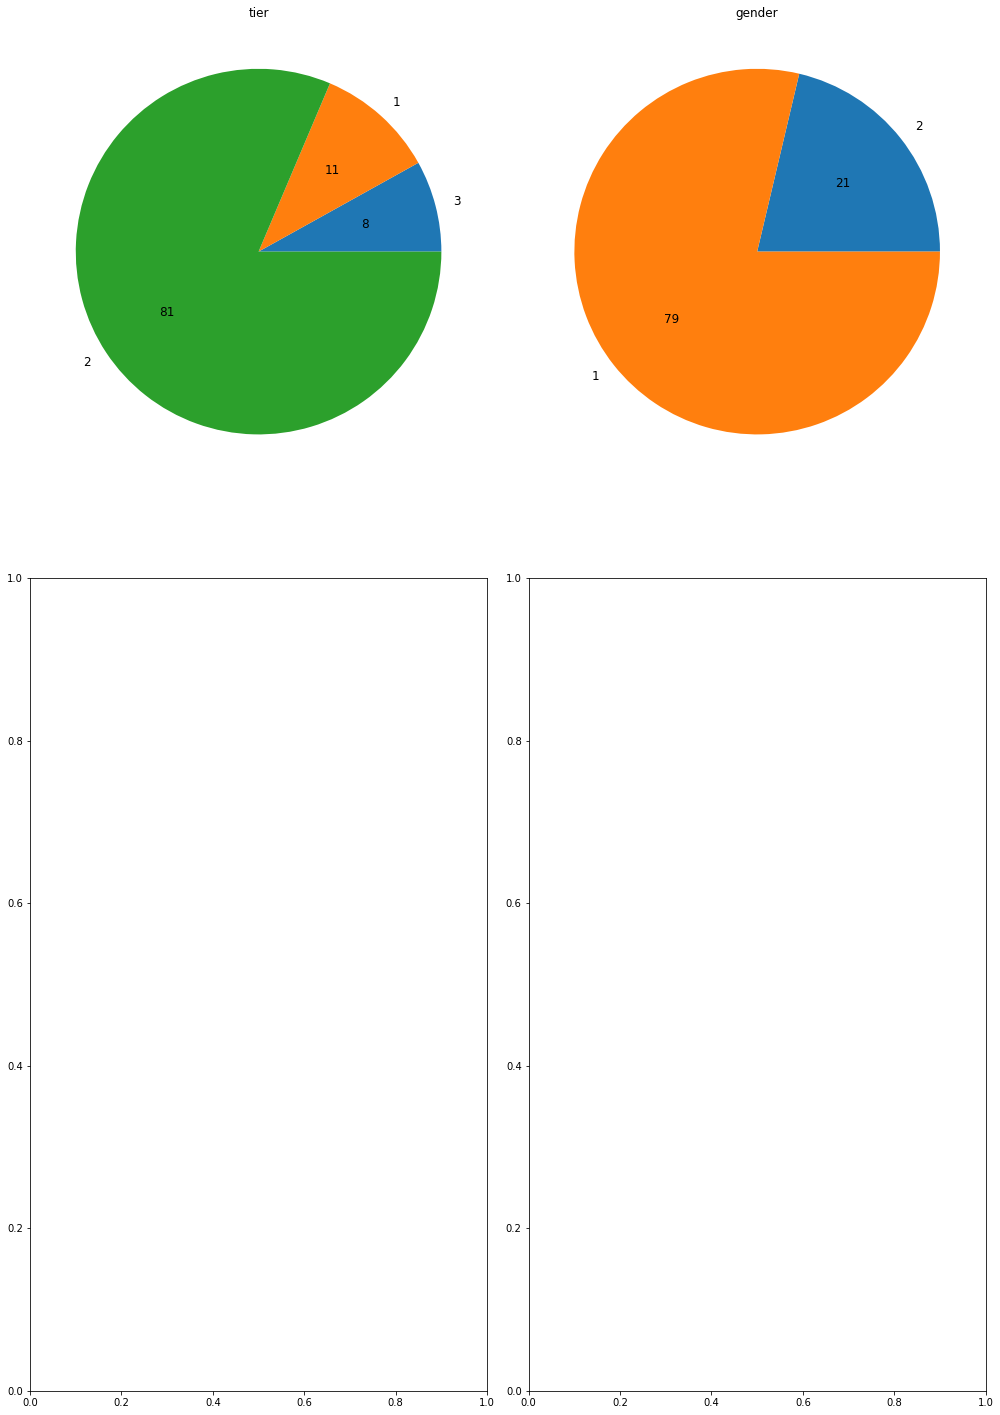

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(df_train[cat_cols]):
    _ = df_train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

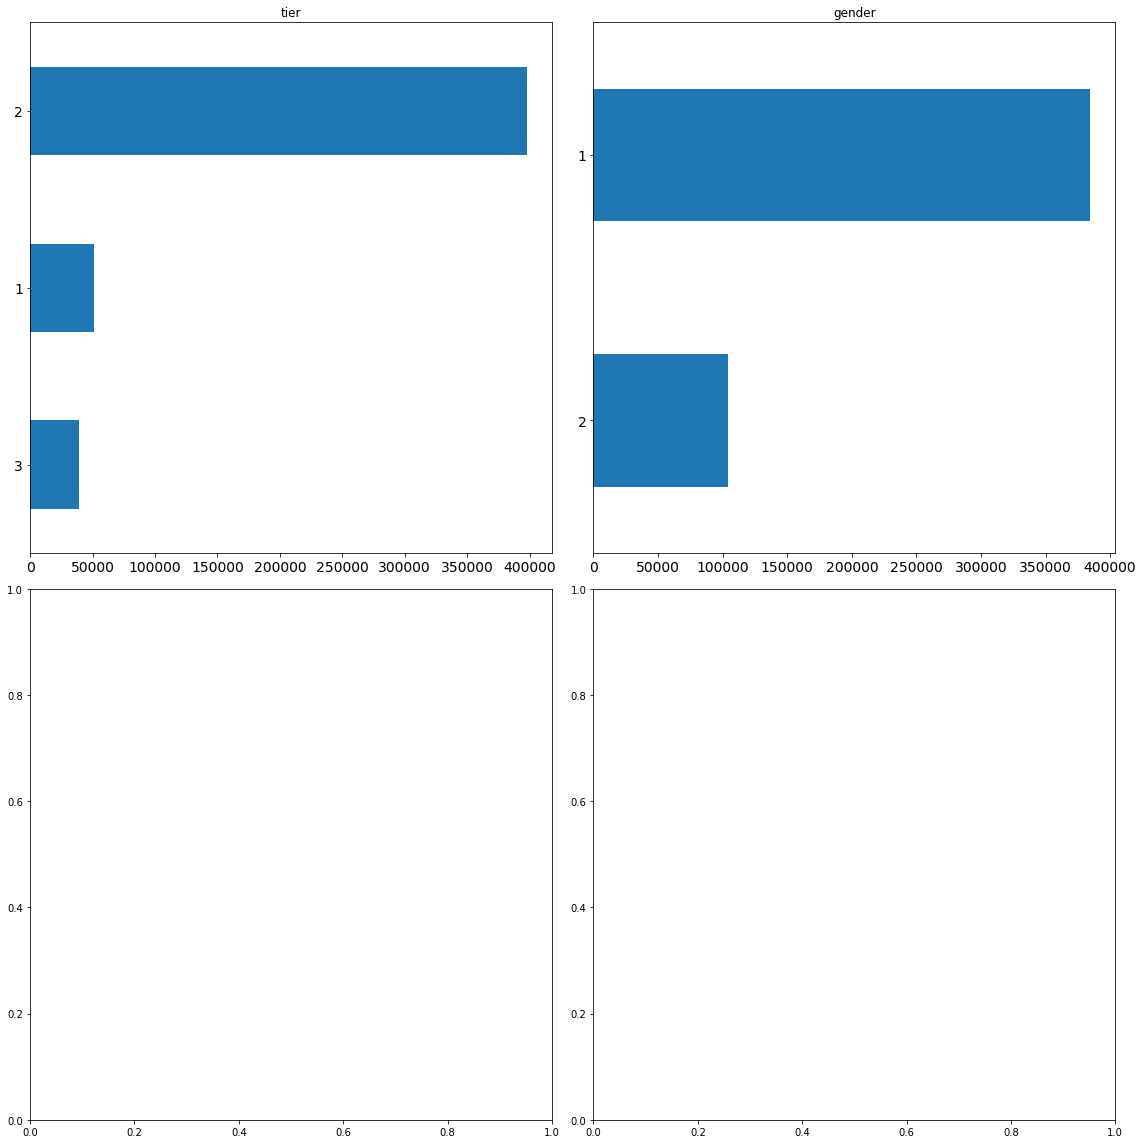

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(df_train[cat_cols]):
    _ = df_train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

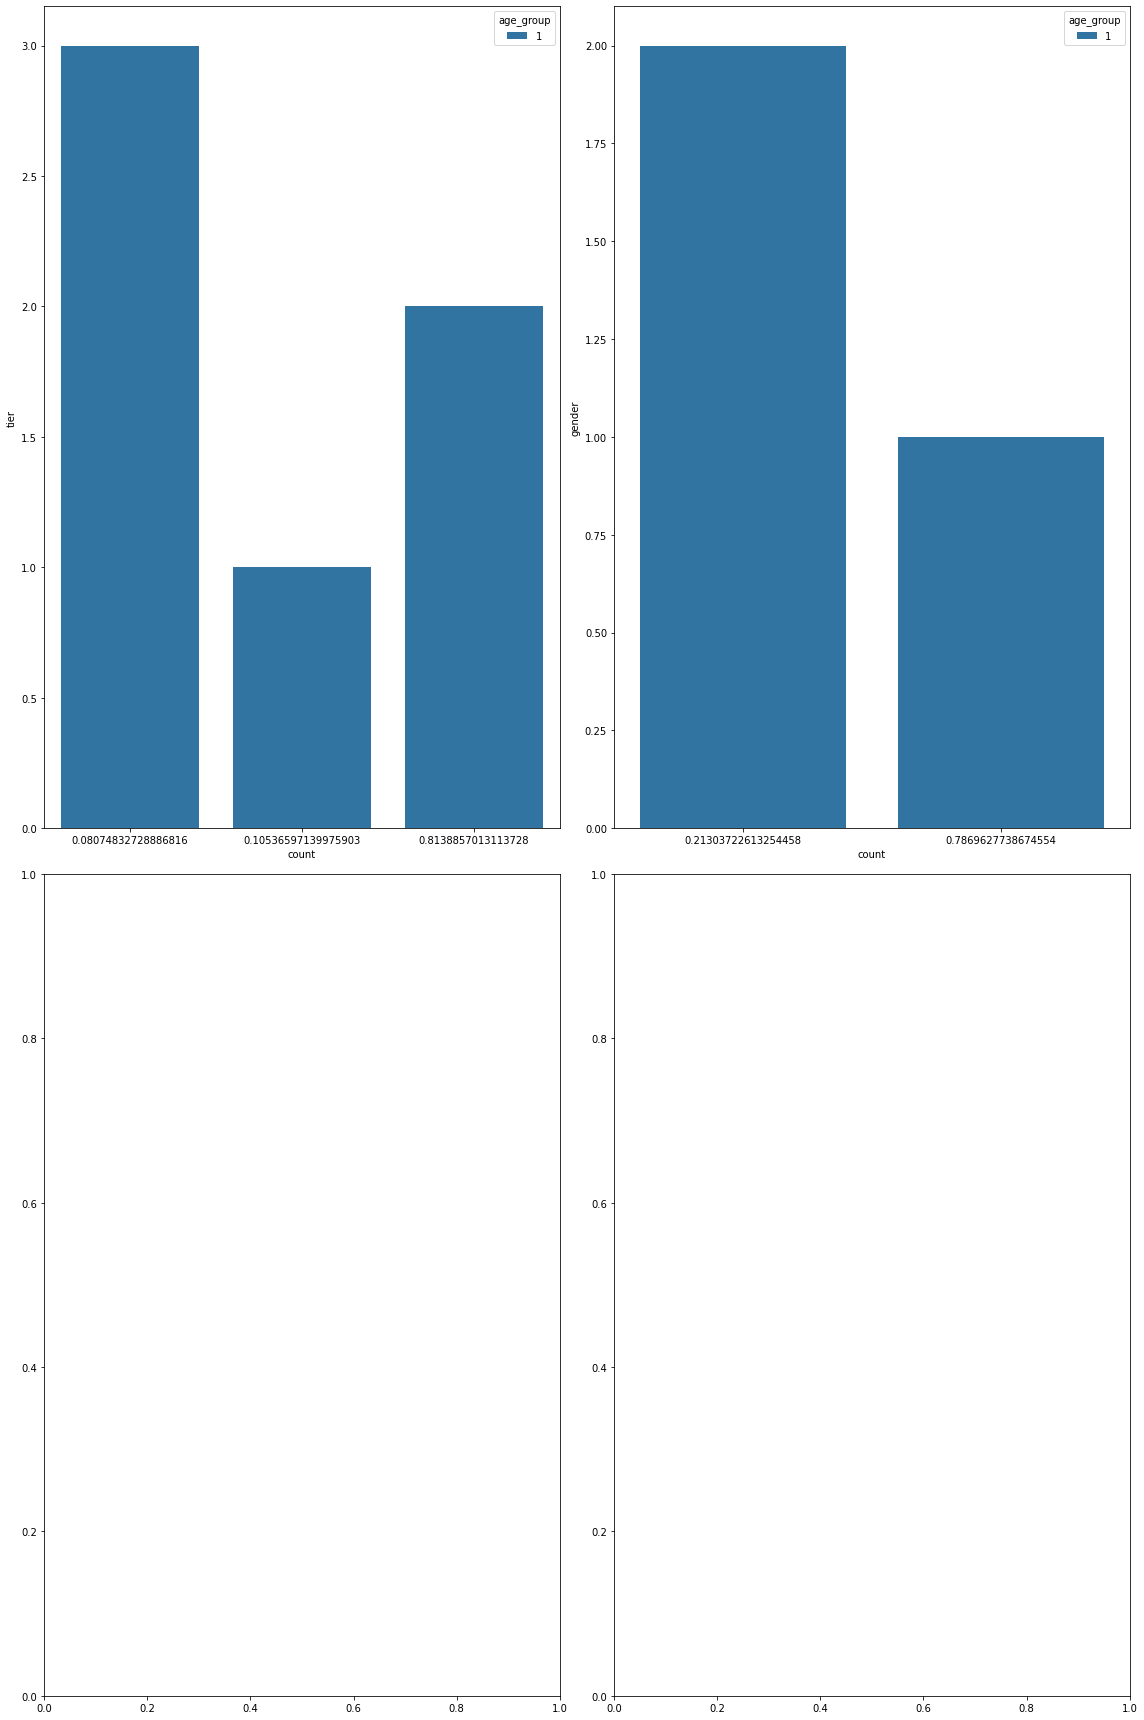